# Diabetes Patients Readmissions Prediction

**Authors:** Peter Macinec, Frantisek Sefcik

## Data Analysis

In this jupyter notebook, we will analyze the data, their distributions and check how each attribute can help in predicting the readmission of patient.

### Setup and import libraries

In [1]:
# Automatically reloading imported
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import string
from functools import reduce

import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Change design of plots
sns.set(style="whitegrid")

# Change sizes and resolution of plots
plt.rcParams['figure.figsize'] = (10, 6)
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 15})

### Descriptive data analysis

As we checked the data previously (first look at the data), we found out that missing values are represented as question mark `'?'`. Library used for reading the data (`pandas`) has options to set which values should be read as missing (NaN).

Let's read the data:

In [4]:
df = pd.read_csv('../data/data.csv', na_values='?', low_memory=False)

How the data look like? How many of the data are available and how many of attributes are included?

In [5]:
df.shape

(101766, 50)

In [6]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


Are there any duplicated rows?

In [7]:
df.duplicated().any()

False

Even there are no duplicates, the records represent individual encounters, so there can be more encounters for only one patient. Let's check the number of encounters and number of patients:

In [8]:
len(df.encounter_id.unique()), len(df.patient_nbr.unique())

(101766, 71518)

There are more encounters for some patients, so we will have to check those cases later and handle them if needed.

All of the meaningful attributes will be analysed one by one. For now, let's check basic statistics of numerical attributes:

In [9]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


And also statistics of categorical attributes:

In [10]:
df.describe(exclude=[np.number])

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,99493,101766,101766,3197,61510,51817,101745,101408,100343,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,10,9,17,72,716,748,789,4,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),[75-100),MC,InternalMedicine,428,276,250,None,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,1336,32439,14635,6862,6752,11555,96420,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


From this point of view, we can see that some of the attributes look numerical, but contain also strings (like *None*). We will have to check that better and analyse them individually, because those attributes can represent for example some codes or just the results of some measurements. 

### Predicted class

Our task will be to predict whether will patient be readmitted for diabetes treatment and when (< 30 days, > 30 days).

Naturally, we suppose classes to be unbalanced, let's find out:

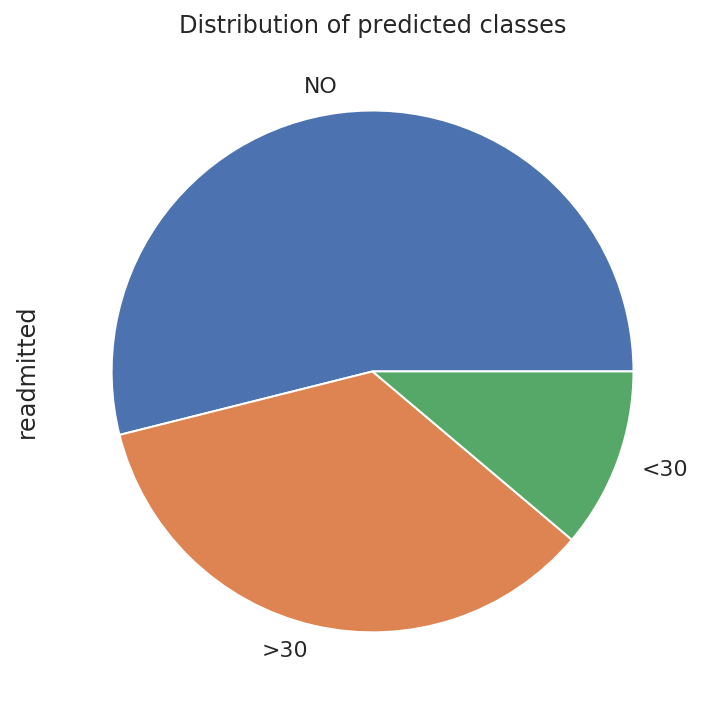

In [11]:
df.readmitted.value_counts().plot(kind='pie', title='Distribution of predicted classes');

In [12]:
df.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

**Even though the dataset contains 3 classes to be predicted, we transformed our task to binary classification - whether will patient be readmitted or not (regardless of days the patient returned).**

In [13]:
df['label'] = df.readmitted.apply(lambda x: 0 if x == 'NO' else 1)

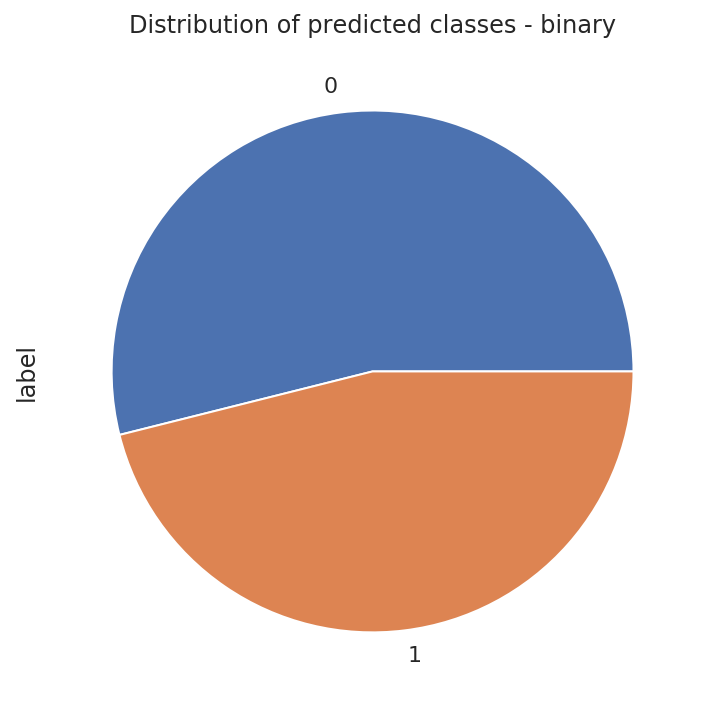

In [14]:
df.label.value_counts().plot(kind='pie', title='Distribution of predicted classes - binary');

In [15]:
df.label.value_counts()

0    54864
1    46902
Name: label, dtype: int64

### Missing values

From first view of the data, we could see that there are also missing values. We could see also some rows with *None* values, but those values mean that measurement was not done (according to paper that published this dataset [1]). In those cases, *None* value does not represent missing value - information about not performing the measurement can be helpful when predicting patient readmission.

Let's check which columns have missing values and how many (the bar represents the fraction of data that are available - lower the bar, the more missing values are there):

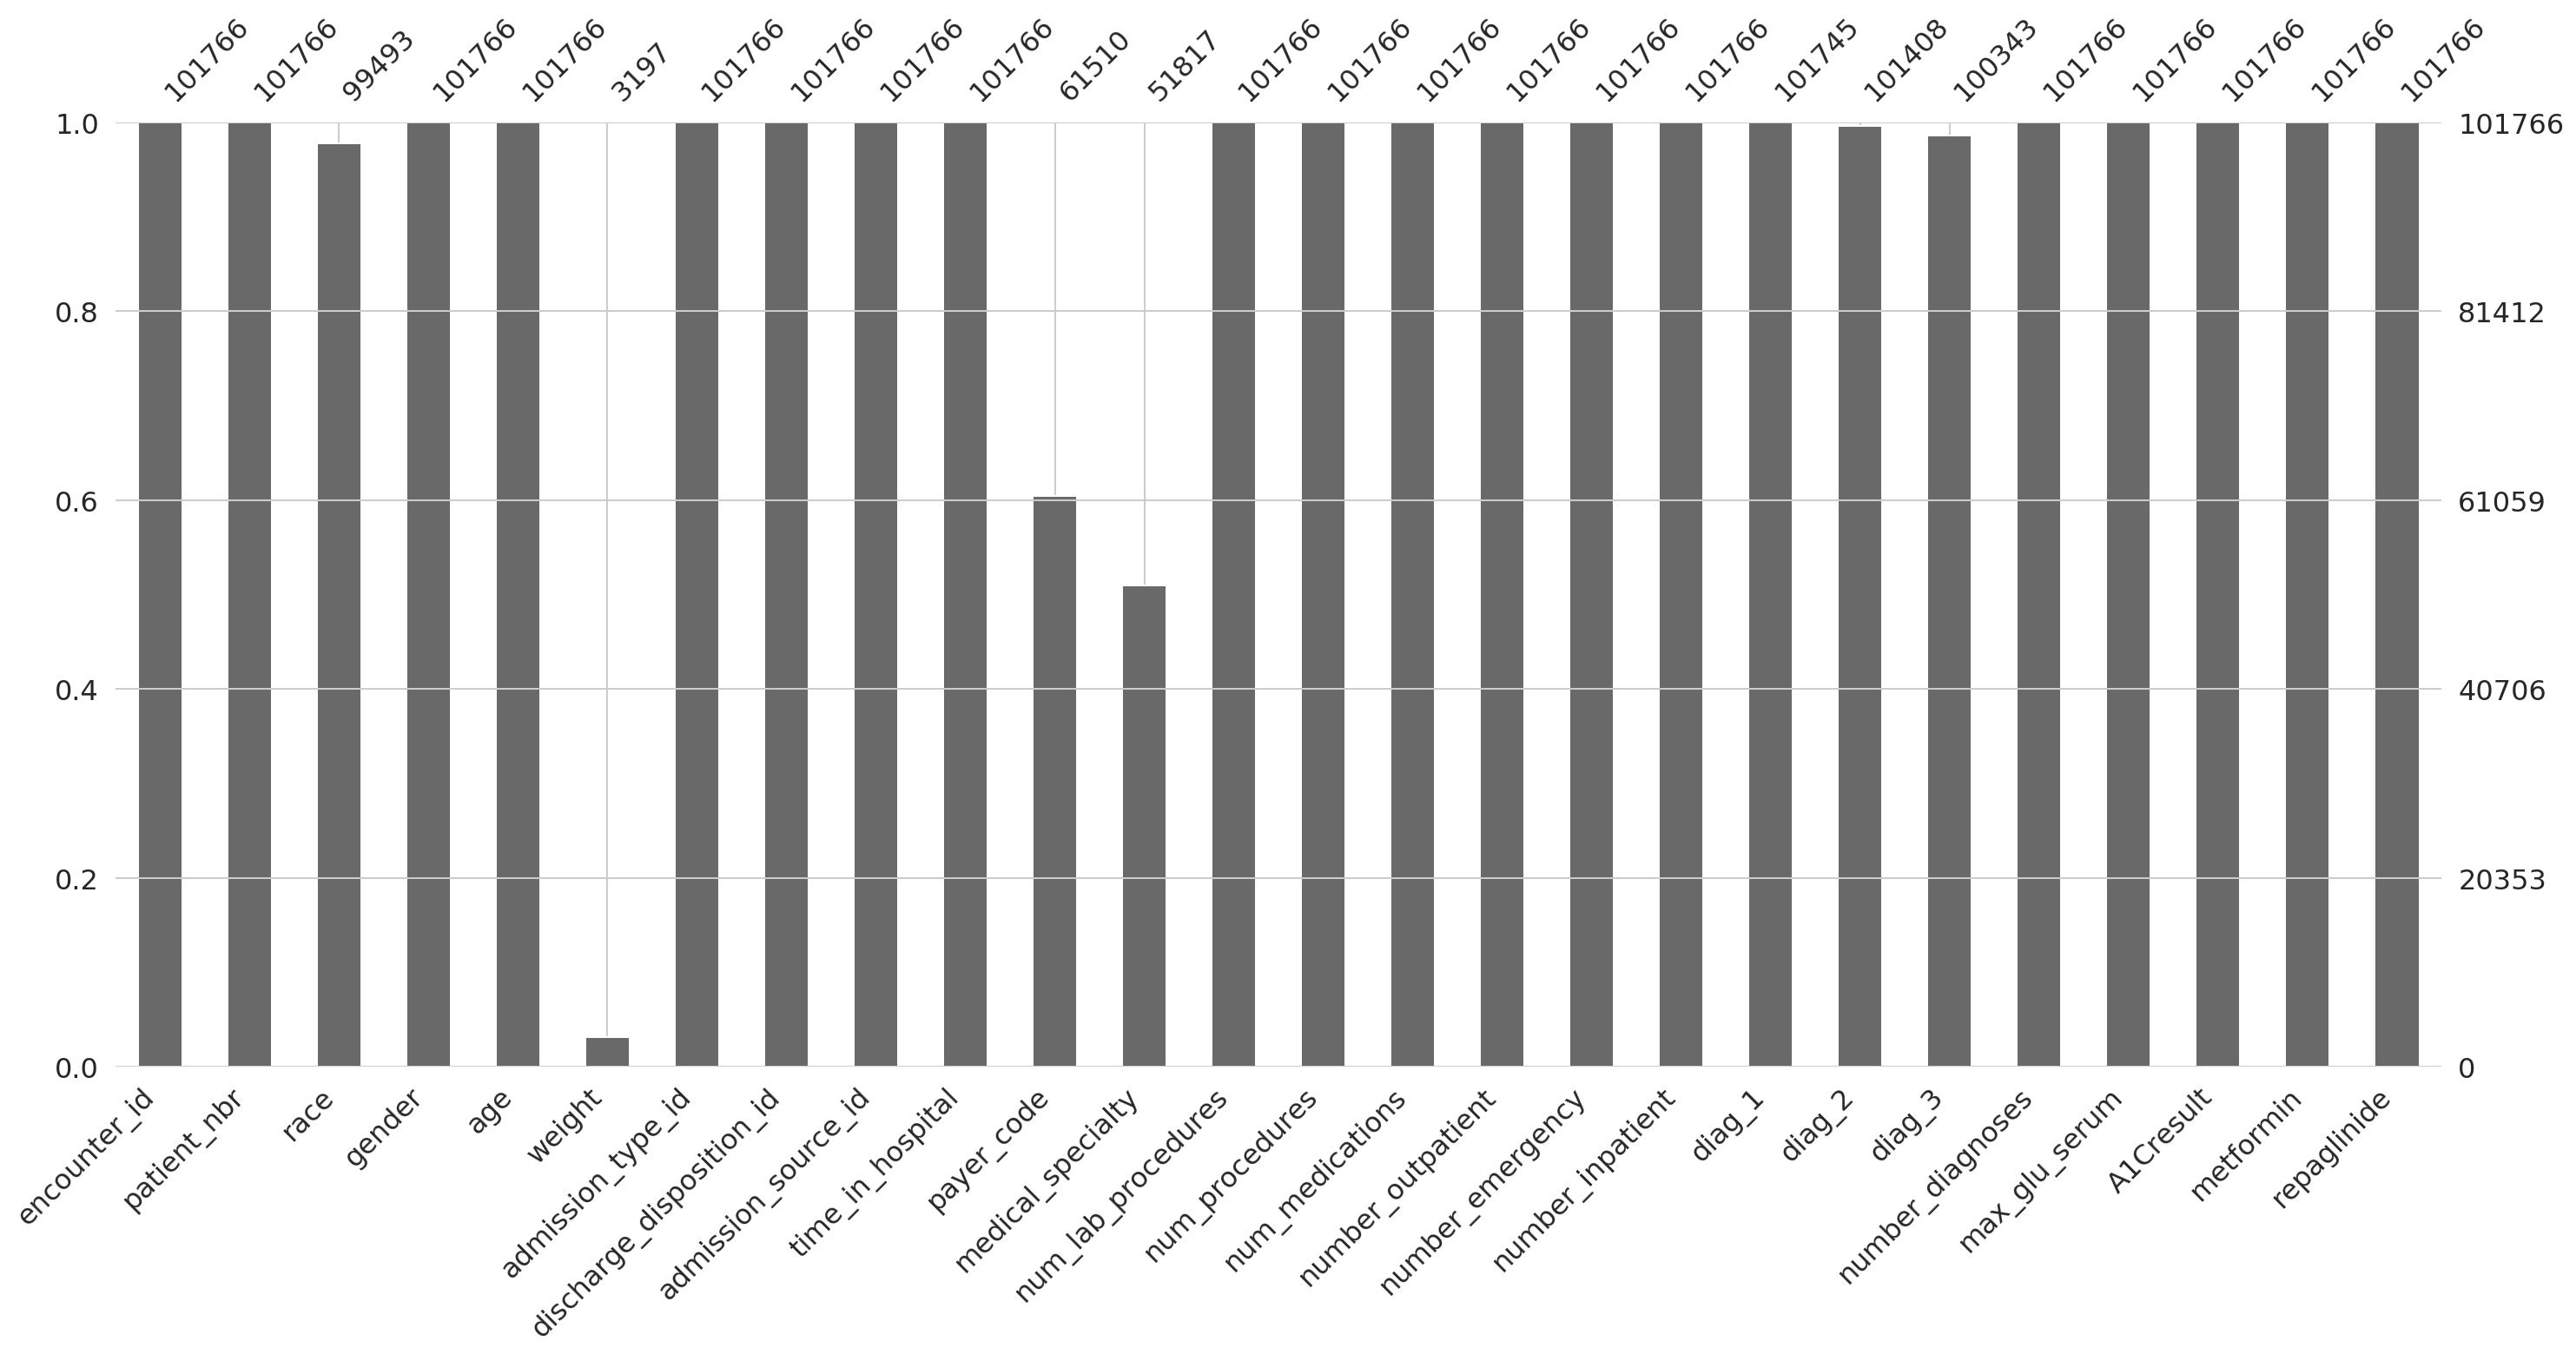

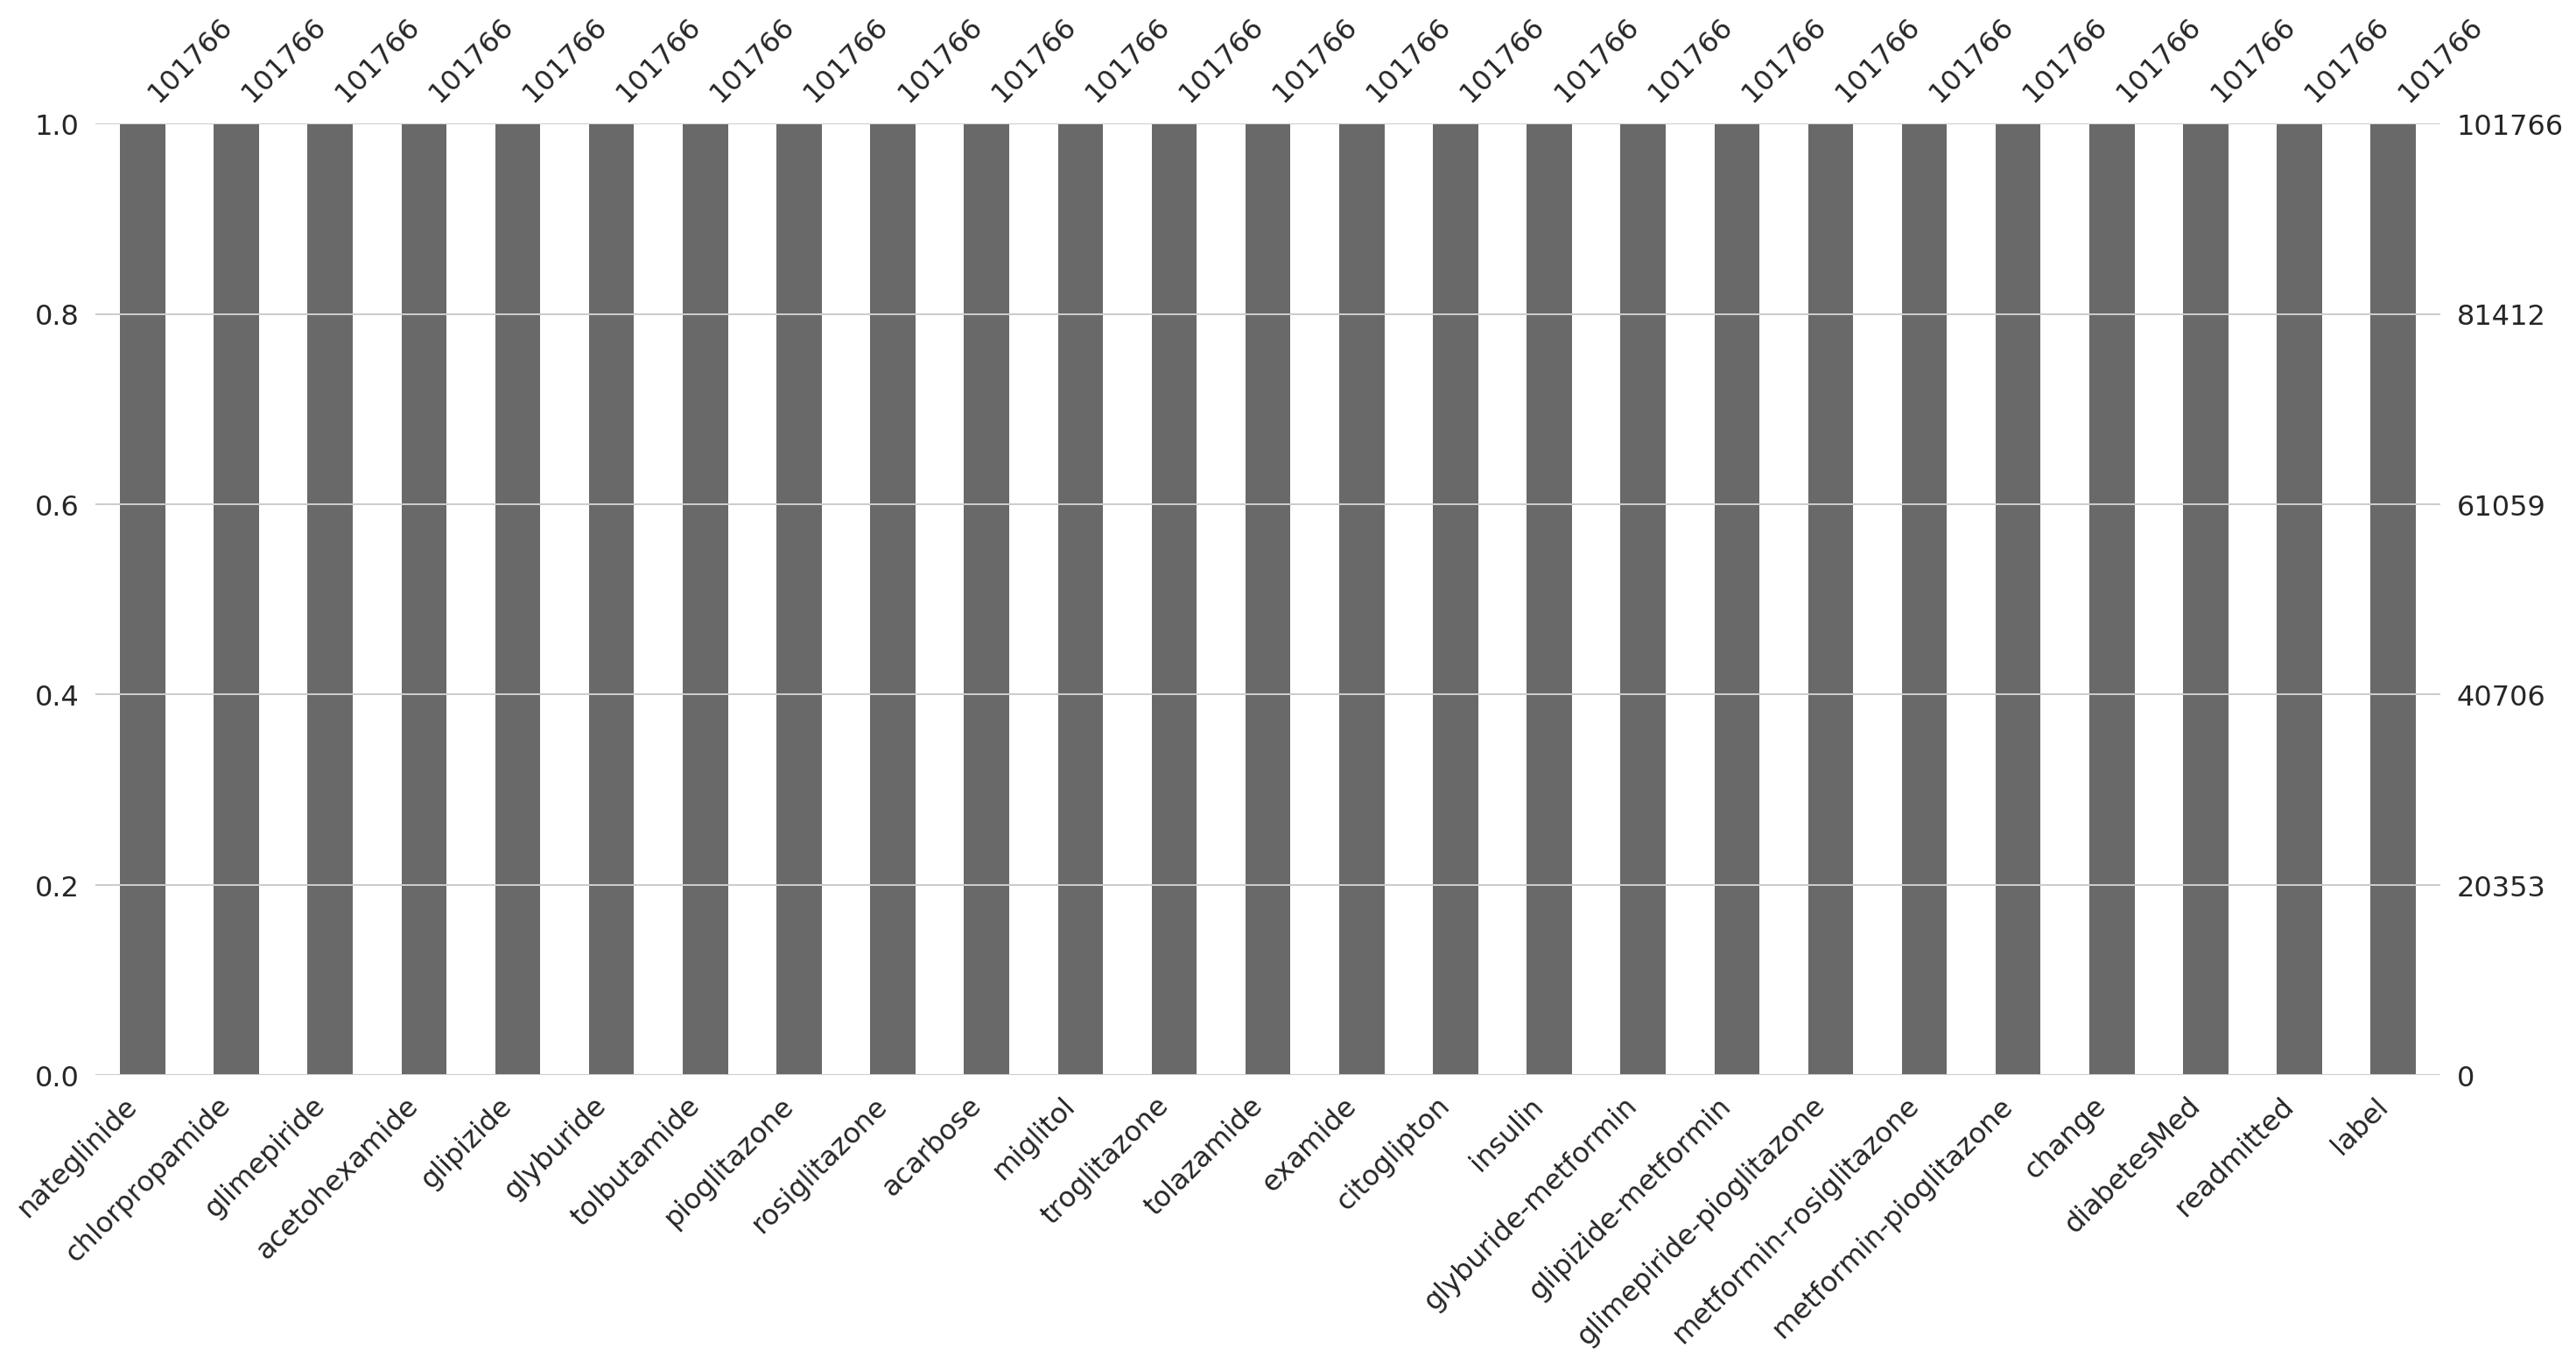

In [16]:
# Divide columns to 2 groups (too many columns for one plot)
column_groups = np.array_split(df.columns, 2)

for columns in column_groups:
    msno.bar(df[columns])
    plt.show()

### Attributes analysis

In this section, we will analyse all meaningful attributes one by one.

#### Functions definitions

In [17]:
def missing_values(df, attribute):
    """
    Check number of missing values in selected attribute.
    
    :param df: dataframe with data.
    :param attribute: name of attribute to check missing values.
    """
    num_missing = len(df[df[attribute].isnull()])
    missing_percentage = round(num_missing / len(df) * 100, 2)
    print(f'Number of missing values: {num_missing} ({missing_percentage}%)')


def barplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, topn=None, ax=None):
    """
    Draw barplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on barplot.
    :param attribute: name of attribute to be drawn on barplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    uniq_values = df[attribute].value_counts().head(topn).index
    df = df[df[attribute].isin(uniq_values)]
    data = df.groupby(groupby)[attribute].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
    sns.barplot(attribute, 'percentage', hue=groupby, data=data, ax=ax)
    plt.xticks(rotation=ticks_rotation)
    plt.title(title)

    
def kdeplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Draw kdeplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on kdeplot.
    :param attribute: name of attribute to be drawn on kdeplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    for x in df[groupby].unique():
        sns.kdeplot(df[df[groupby] == x][attribute], label=x, shade=True, shade_lowest=False, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)


def boxplot_per_classes(df, attribute, groupby, title=None, ticks_rotation=0, ax=None):
    """
    Draw boxplot of attribute per each class.
    
    :param df: dataframe with data to be drawn on boxplot.
    :param attribute: name of attribute to be drawn on boxplot.
    :param groupby: name of attribute with predicted classes.
    :param title: title of plot.
    :param ticks_rotation: rotation of x-ticks (labels).
    :param ax: matplotlib Axes object to draw the plot onto.
    """
    sns.boxplot(x=groupby, y=attribute, data=df, ax=ax)
    plt.title(title)
    plt.xticks(rotation=ticks_rotation)

All the columns that the dataset contains:

In [18]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'label'],
      dtype='object')

There are also some attributes that are not meaningful for our prediction (like `encounter_id` or `patient_nbr`). These attributes will not be analysed.

All attributes will be analysed according to predicted classes (1 and 0, readmitted or not).

**NOTE:** All the descriptions of attributes are inspired or taken from original paper [1].

#### race

Race of patient. 

Values: Caucasian, Asian, African, American, Hispanic and other.

In [19]:
missing_values(df, 'race')

Number of missing values: 2273 (2.23%)


In [20]:
df.race.value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

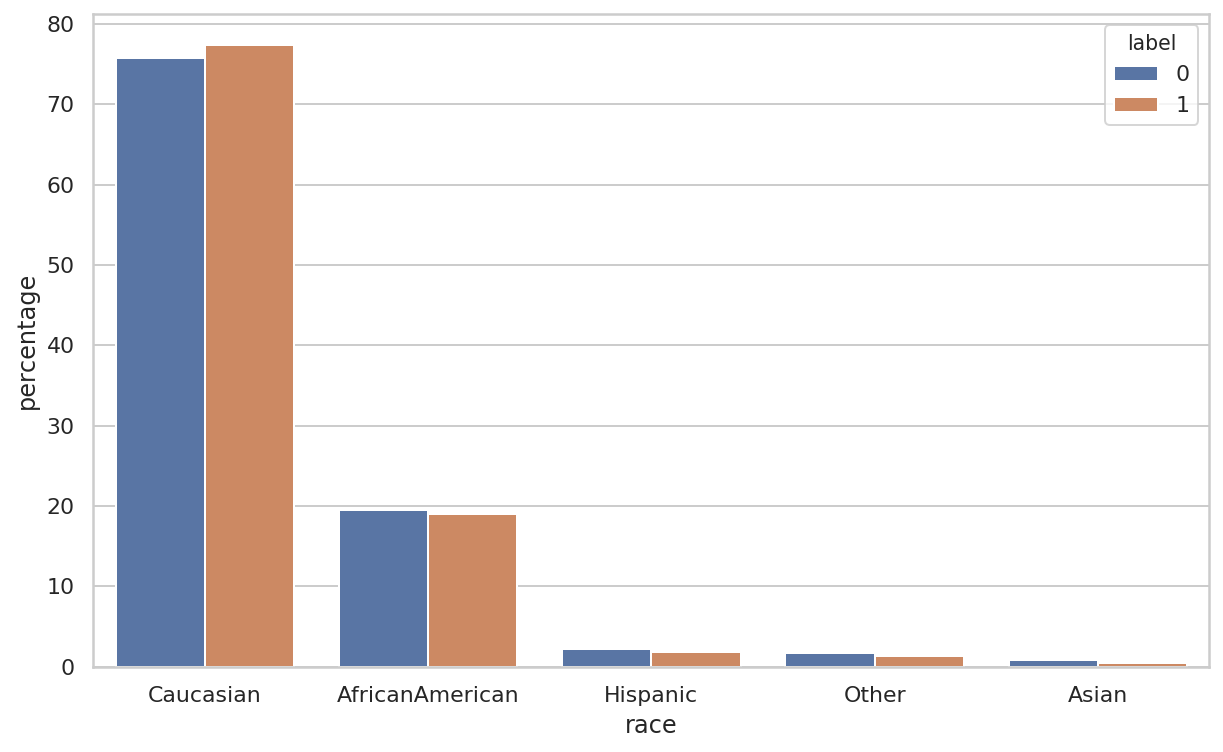

In [21]:
barplot_per_classes(df, 'race', 'label')

#### gender

Gender of patient.

In [22]:
df.gender.value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

As we can see, there are also 3 values that are *unknown/invalid*. Those 3 values should be changed to *male*/*female*, just like when NaN values are filled.

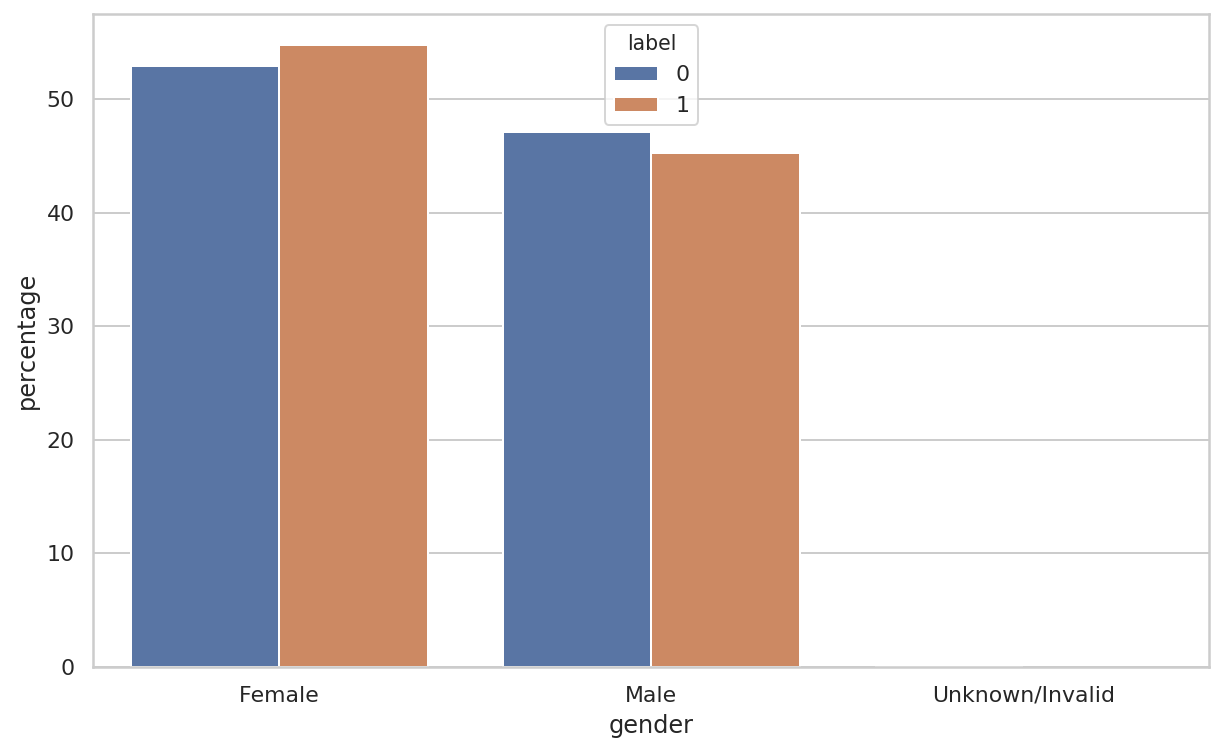

In [23]:
barplot_per_classes(df, 'gender', 'label')

#### age

Age of patient. Grouped in 10-years intervals: [0,10), [10,20), ..., [90,100).

In [24]:
df.age.value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

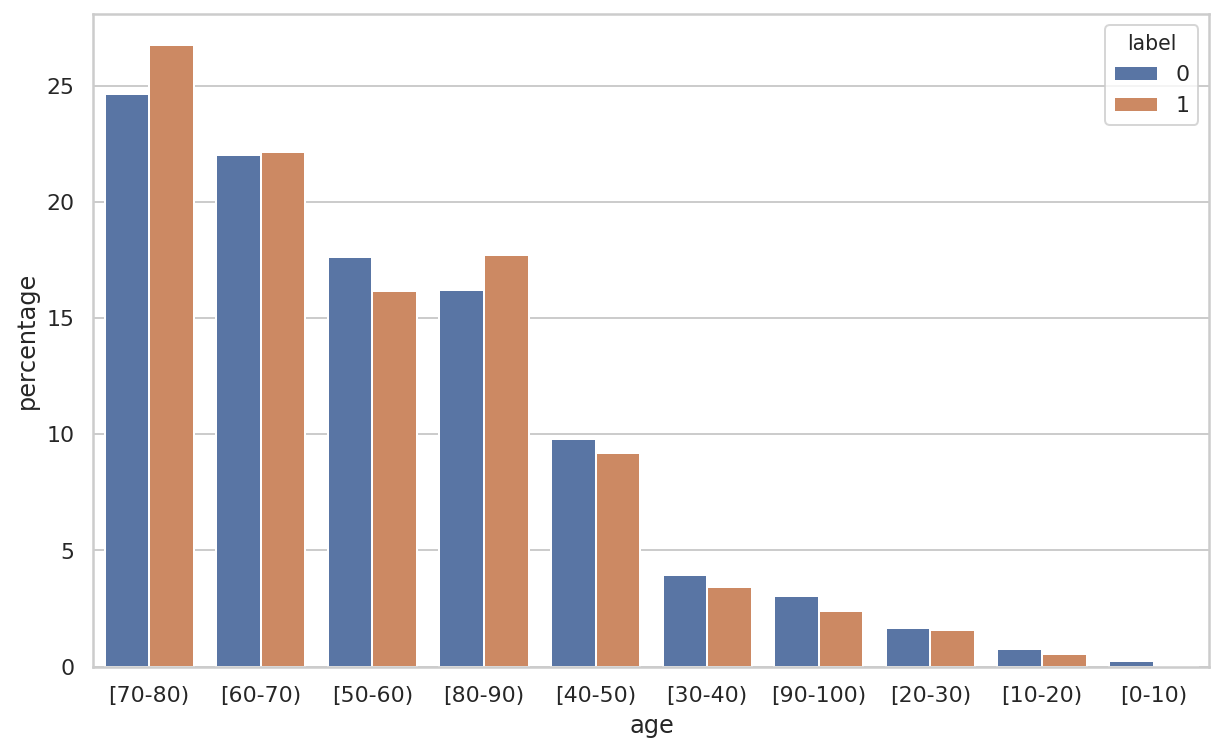

In [25]:
barplot_per_classes(df, 'age', 'label')

#### weight

Weight of patient in pounds. Grouped in 25 pounds intervals.

In [26]:
missing_values(df, 'weight')

Number of missing values: 98569 (96.86%)


As we can see, this column has almost everywhere missing values. We will rather drop it in preprocessing phase.

In [27]:
df.weight.value_counts()

[75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64

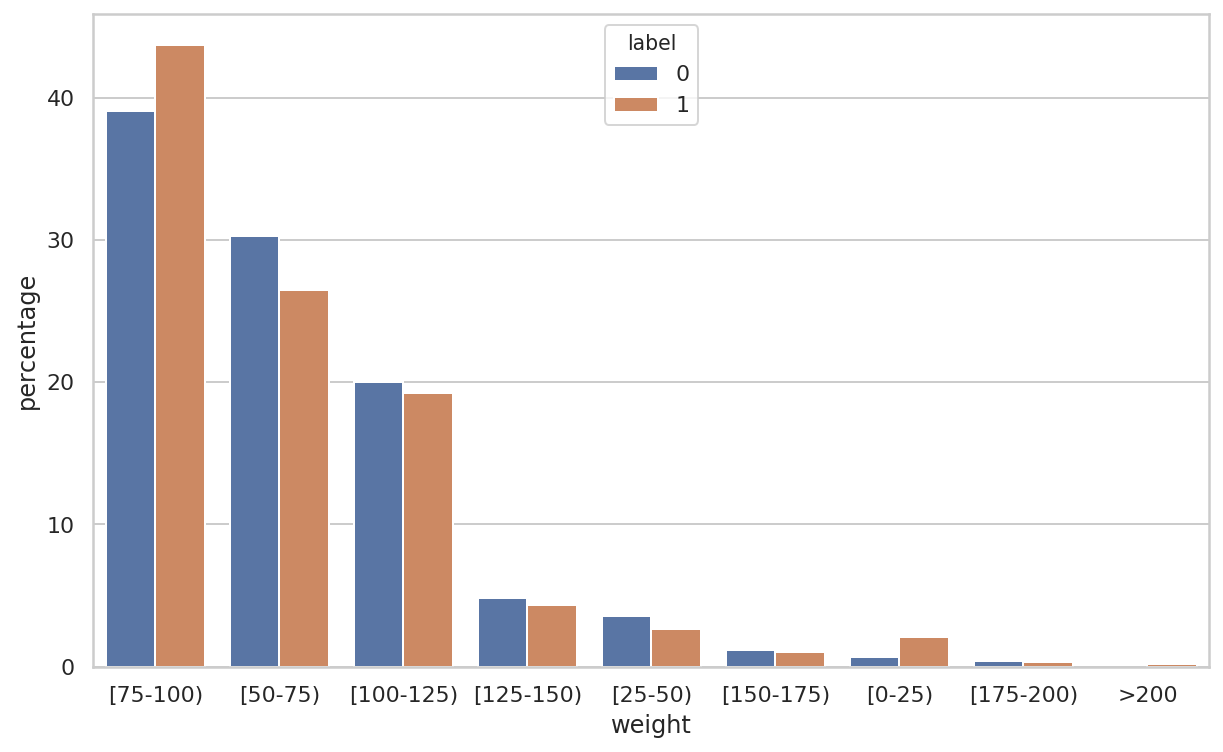

In [28]:
barplot_per_classes(df, 'weight', 'label')

#### admission_type_id

Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available.

In [29]:
df.admission_type_id.value_counts()

1    53990
3    18869
2    18480
6     5291
5     4785
8      320
7       21
4       10
Name: admission_type_id, dtype: int64

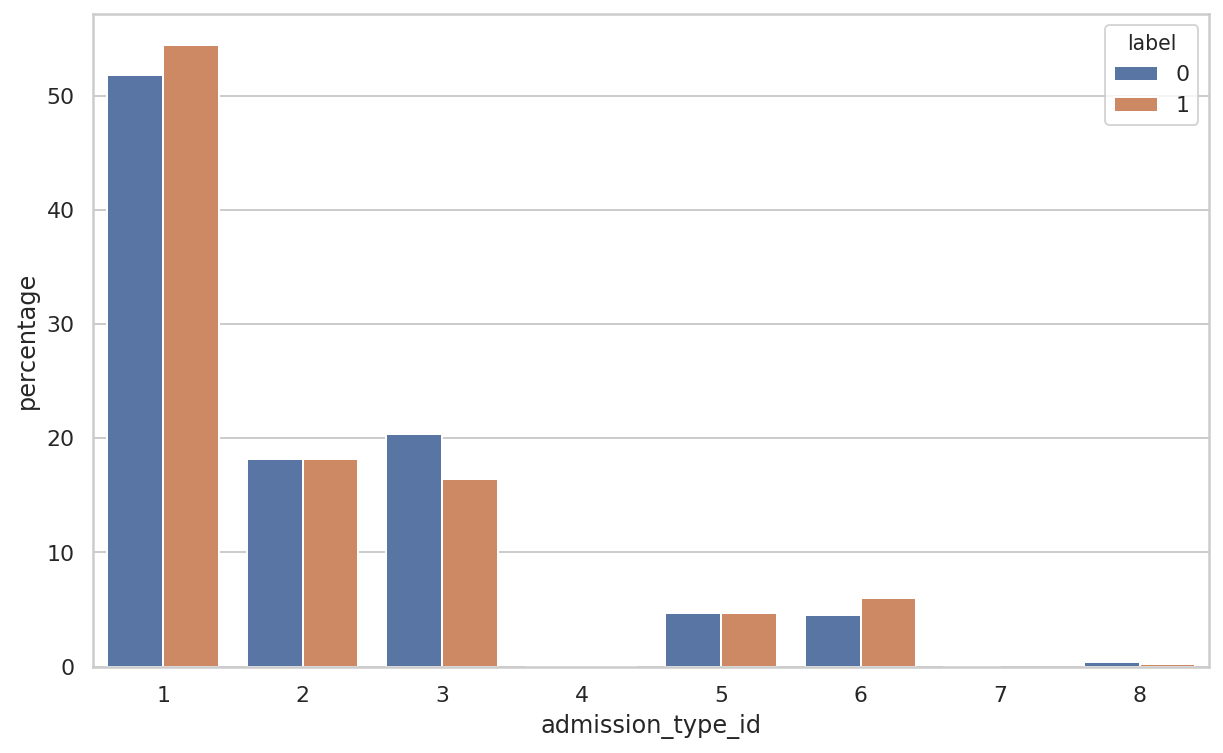

In [30]:
barplot_per_classes(df, 'admission_type_id', 'label')

#### discharge_disposition_id

Itenger identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available.

In [31]:
df.discharge_disposition_id.value_counts()

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

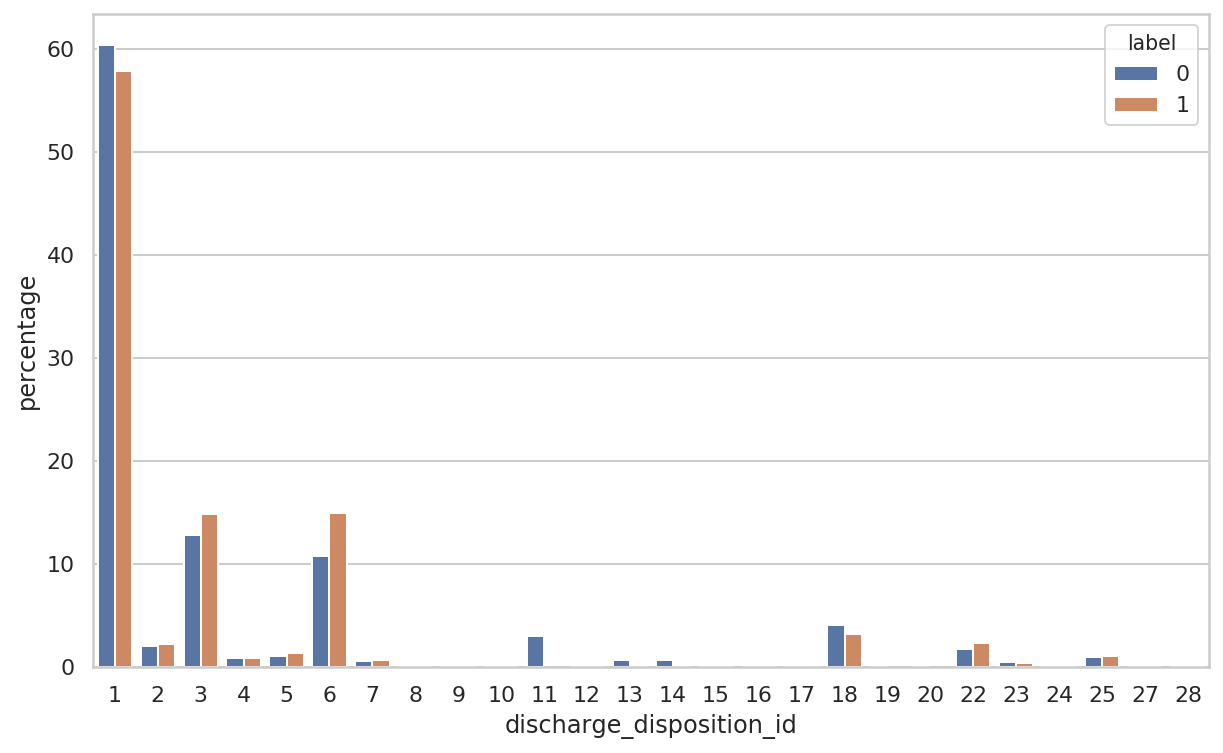

In [32]:
barplot_per_classes(df, 'discharge_disposition_id', 'label')

#### admission_source_id

Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from hospital.

In [33]:
df.admission_source_id.value_counts()

7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
11        2
14        2
25        2
13        1
Name: admission_source_id, dtype: int64

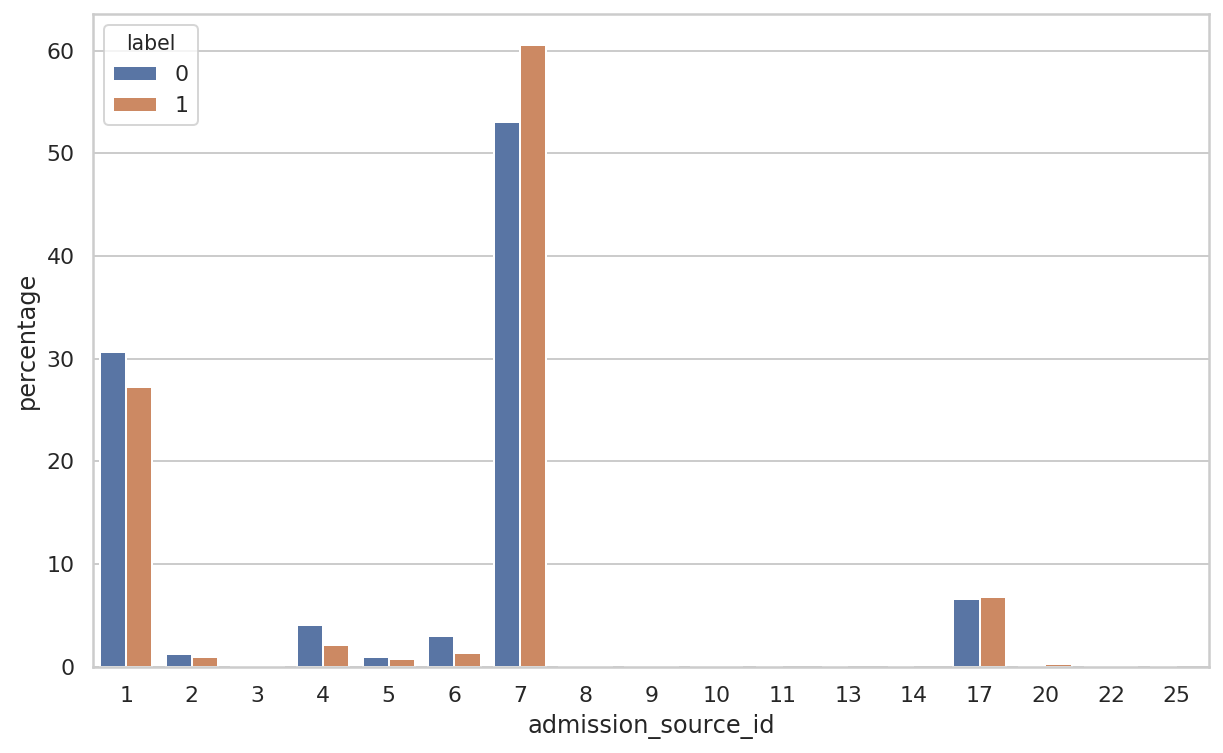

In [34]:
barplot_per_classes(df, 'admission_source_id', 'label')

#### time_in_hospital

Integer number of days between admission and discharge.

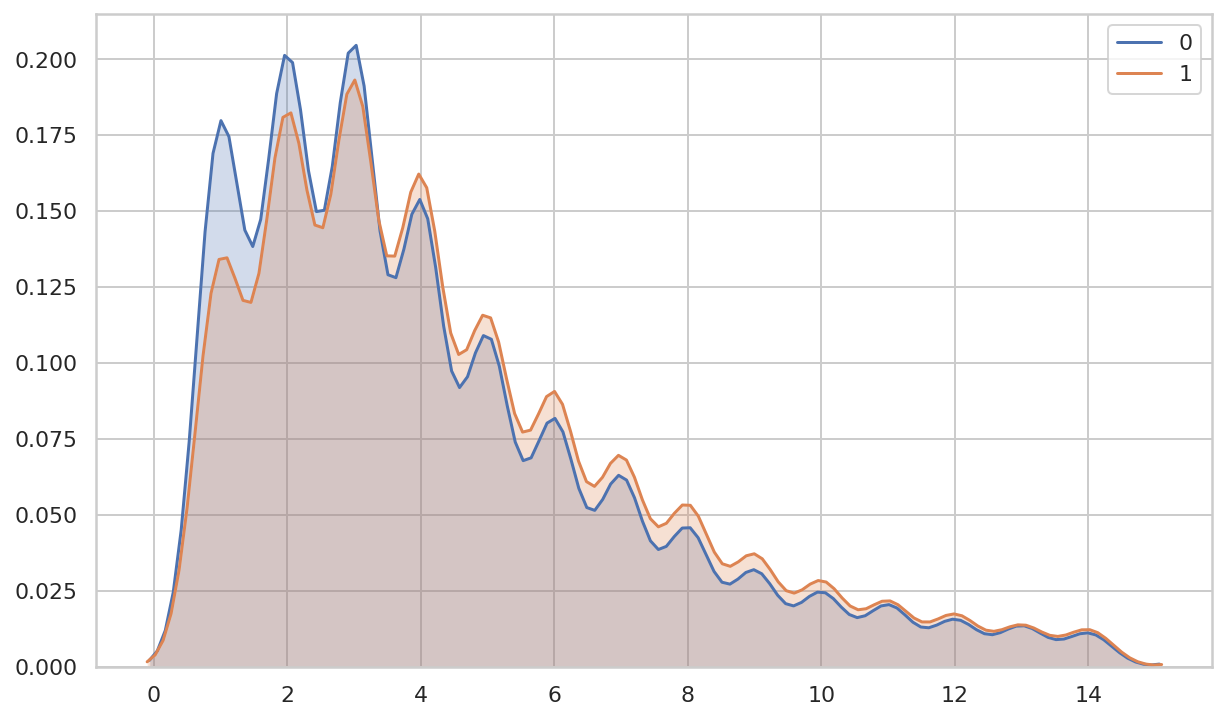

In [35]:
kdeplot_per_classes(df, 'time_in_hospital', 'label')

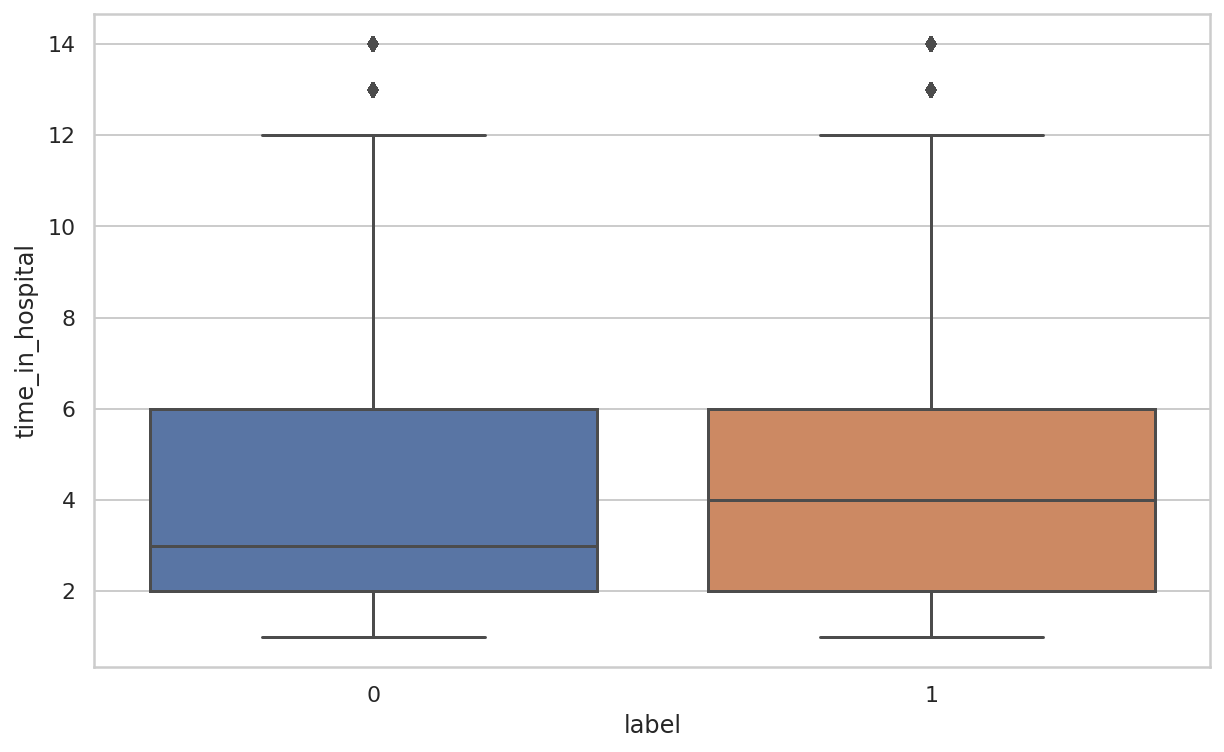

In [36]:
boxplot_per_classes(df, 'time_in_hospital', 'label')

#### payer_code

Integer identifier corresponding to 23 distinct values, for example, Blue Cross\Blue Shield, Medicare, and self-pay.

Even if the attribute can be useful in prediction, it can be caused by an accident - naturally, the way how the treatment is payed has no cause to patient readmission (but only if the treatment is not dependent on insurance company).

In [37]:
missing_values(df, 'payer_code')

Number of missing values: 40256 (39.56%)


As we can see, a lot of values are missing. Those values still can be filled/completed, but as mentioned above, this attribute may not influence whether patient will be readmitted or not. In this case, probably better way will be to drop the attribute.

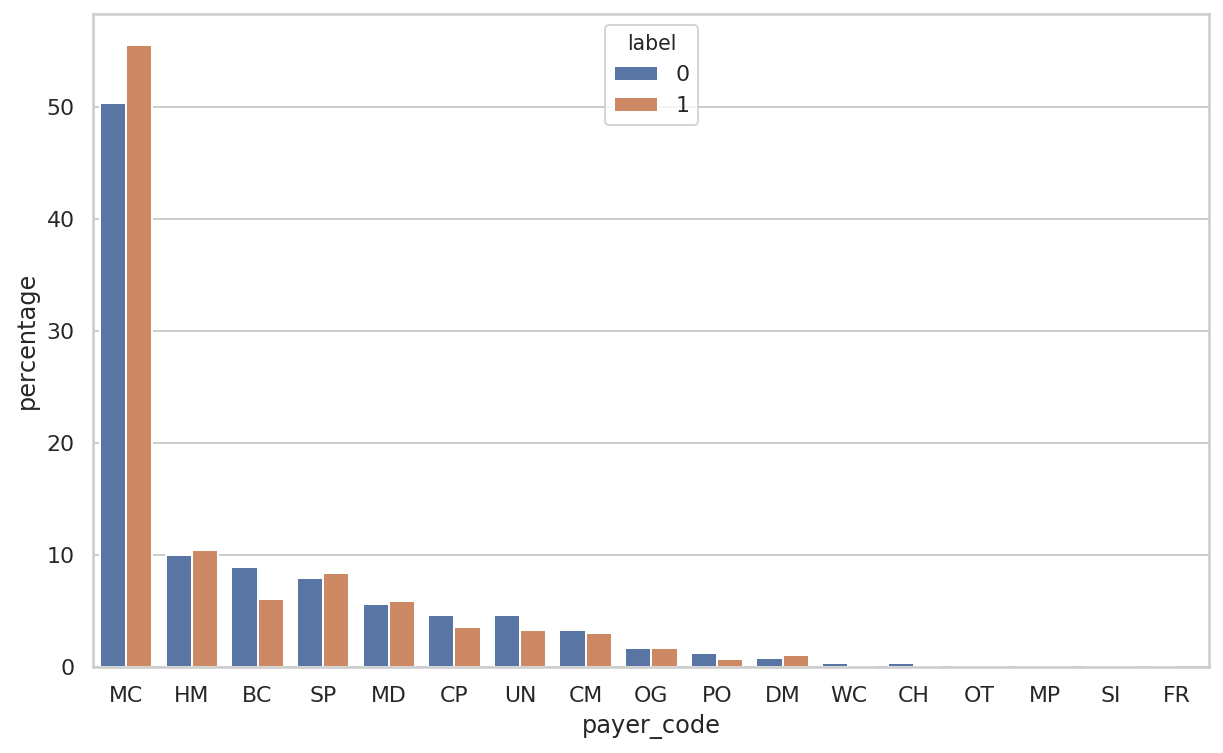

In [38]:
barplot_per_classes(df, 'payer_code', 'label')

#### medical_specialty

Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family\general practice, and surgeon.

In [39]:
missing_values(df, 'medical_specialty')

Number of missing values: 49949 (49.08%)


As there are a lot of distinct values (84), we will only check top 10:

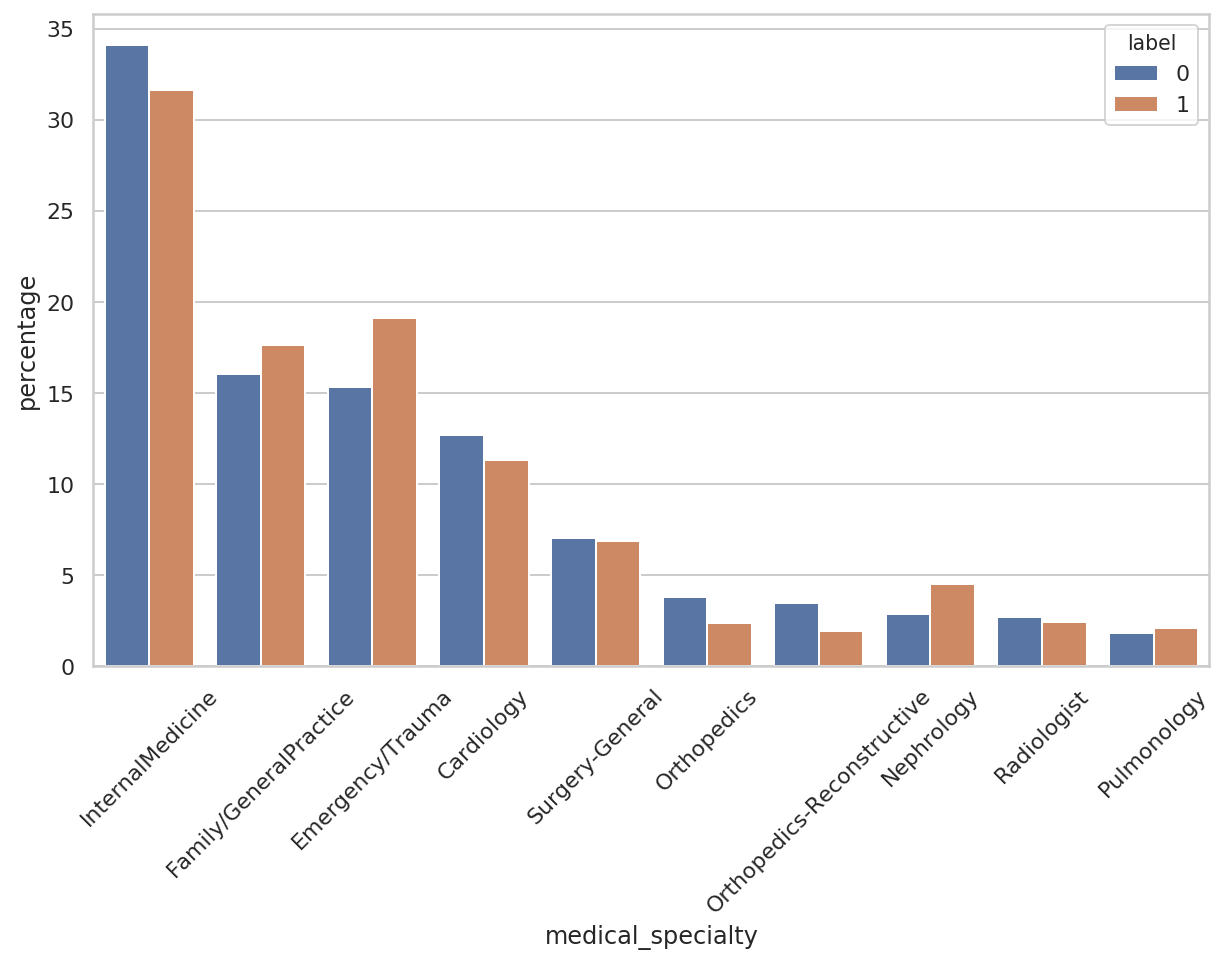

In [40]:
barplot_per_classes(df, 'medical_specialty', 'label', ticks_rotation=45, topn=10)

#### num_lab_procedures

Number of lab tests performed during the encounter.

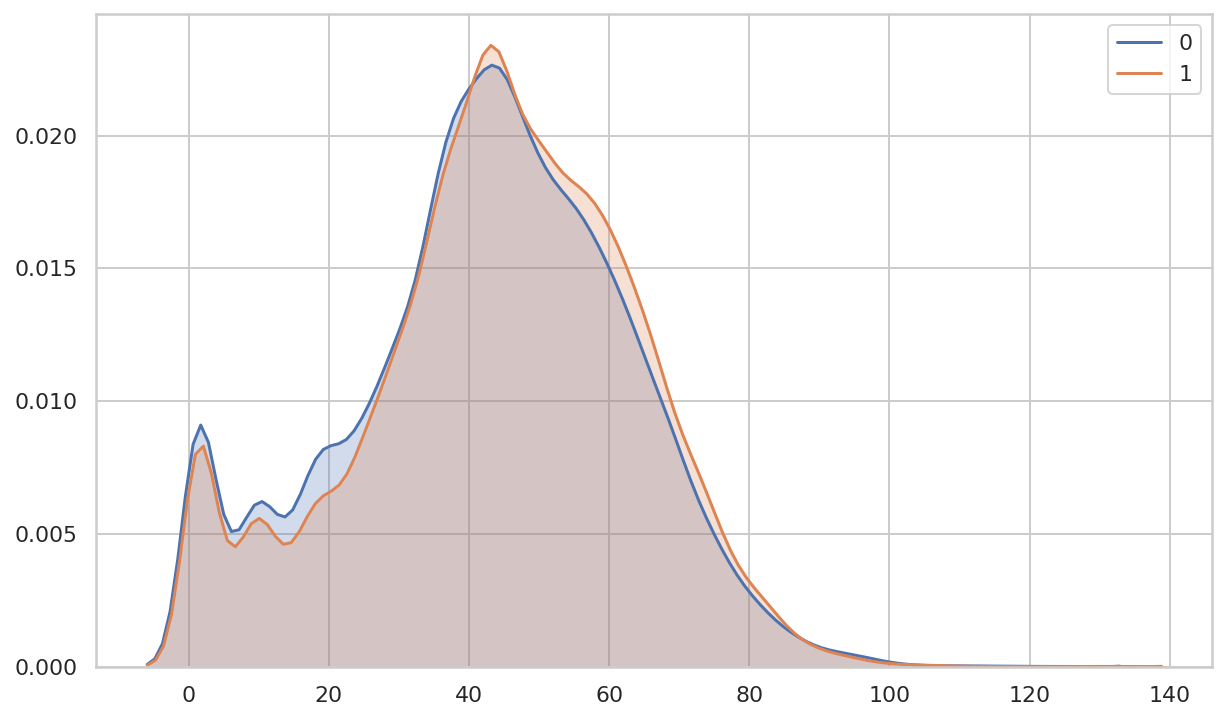

In [41]:
kdeplot_per_classes(df, 'num_lab_procedures', 'label')

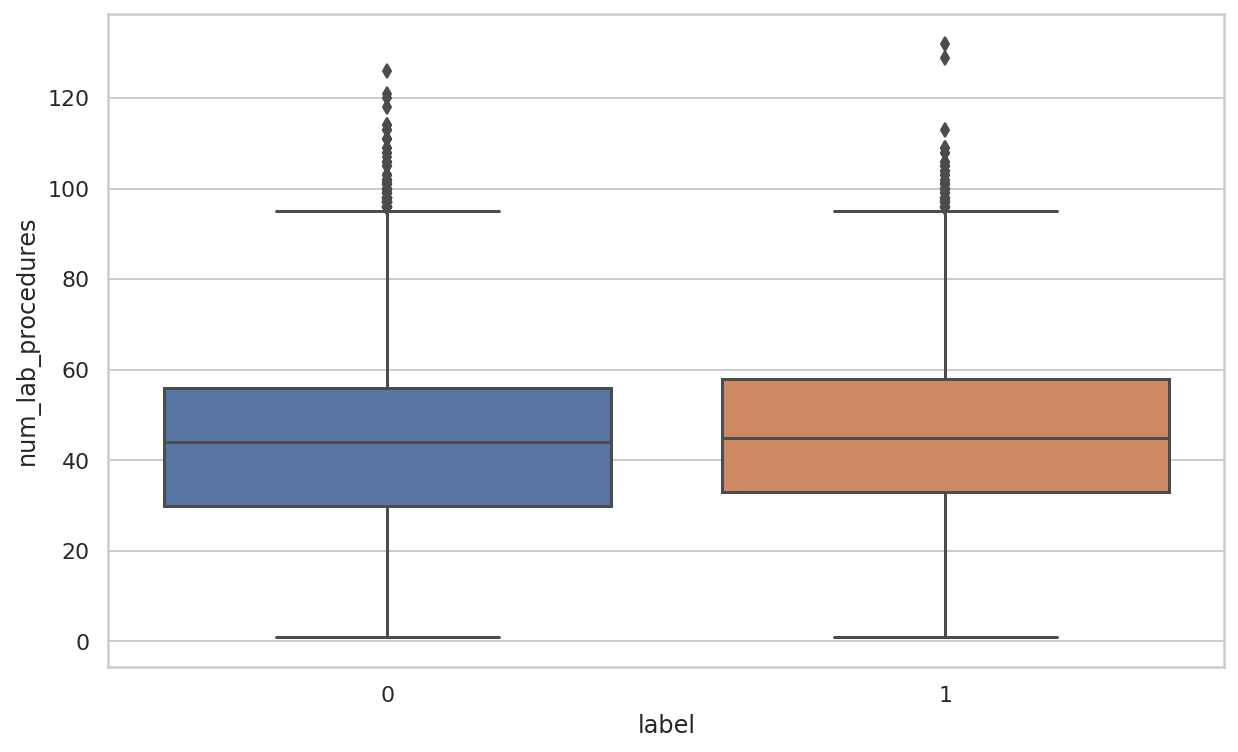

In [42]:
boxplot_per_classes(df, 'num_lab_procedures', 'label')

#### num_procedures

Number of procedures (other than lab tests) performed during the encounter.

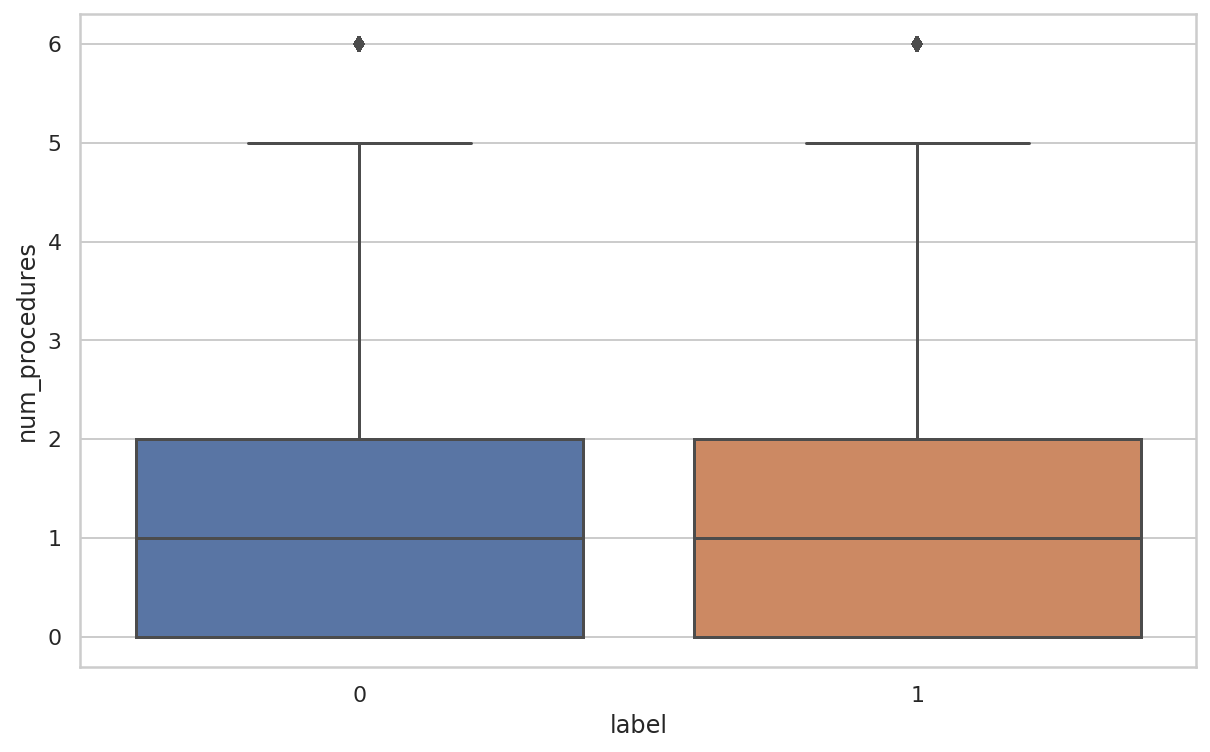

In [43]:
boxplot_per_classes(df, 'num_procedures', 'label')

#### num_medications

Number of distinct generic names administered during the encounter.

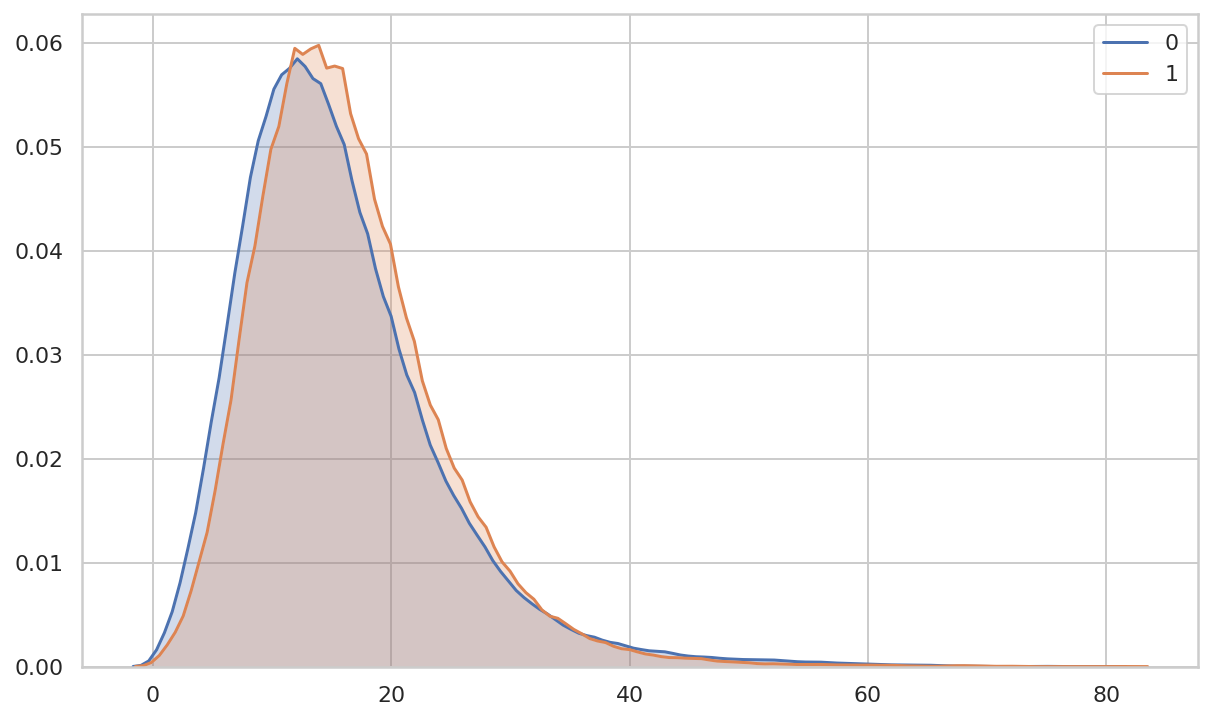

In [44]:
kdeplot_per_classes(df, 'num_medications', 'label')

#### number_outpatient

Number of outpatient visits of the patient in the year preceding the encounter.

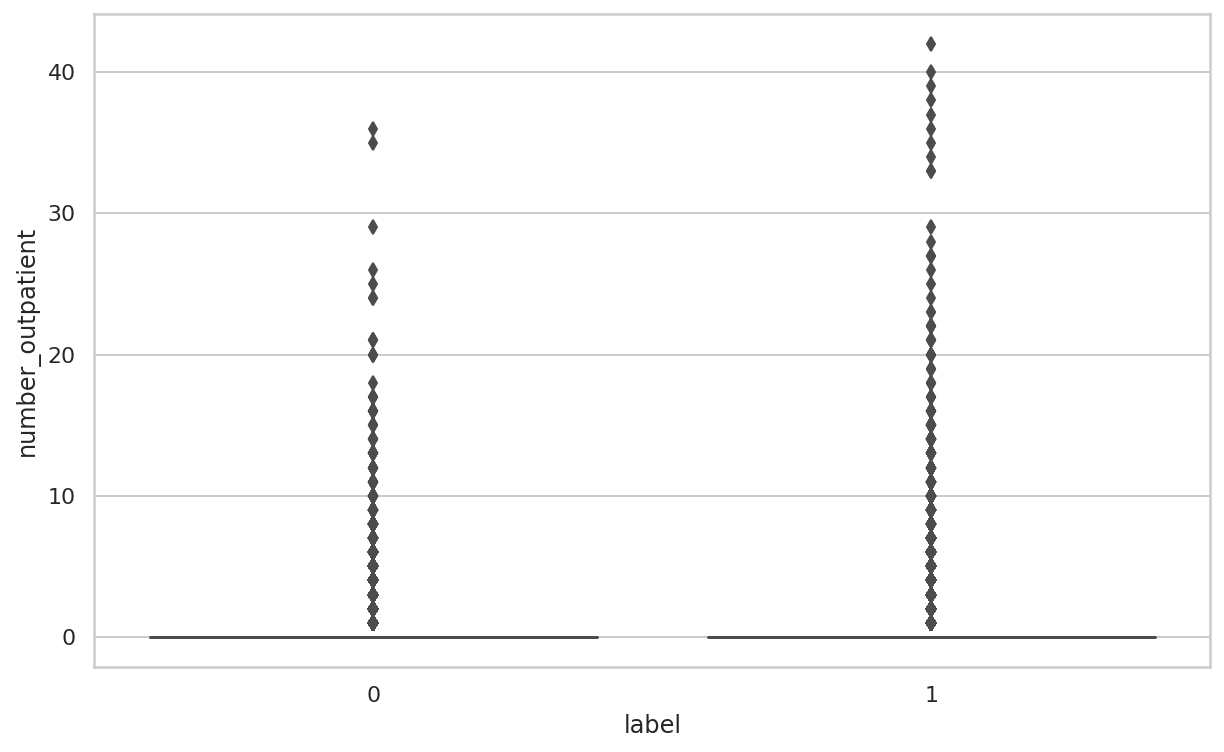

In [45]:
boxplot_per_classes(df, 'number_outpatient', 'label')

As we can see, most of records have value equal to 0. How many percent of all records have visits equal to 0?

In [46]:
print(f'{round(len(df[df.number_outpatient == 0]) / len(df) * 100, 2)}%')

83.55%


It is quite a lot, so probably we will not use this attribute for prediction.

#### number_emergency

Number of emergency visits of the patient in the year preceding the encounter.

This attribute is very similar to the previous one (`number_outpatient`).

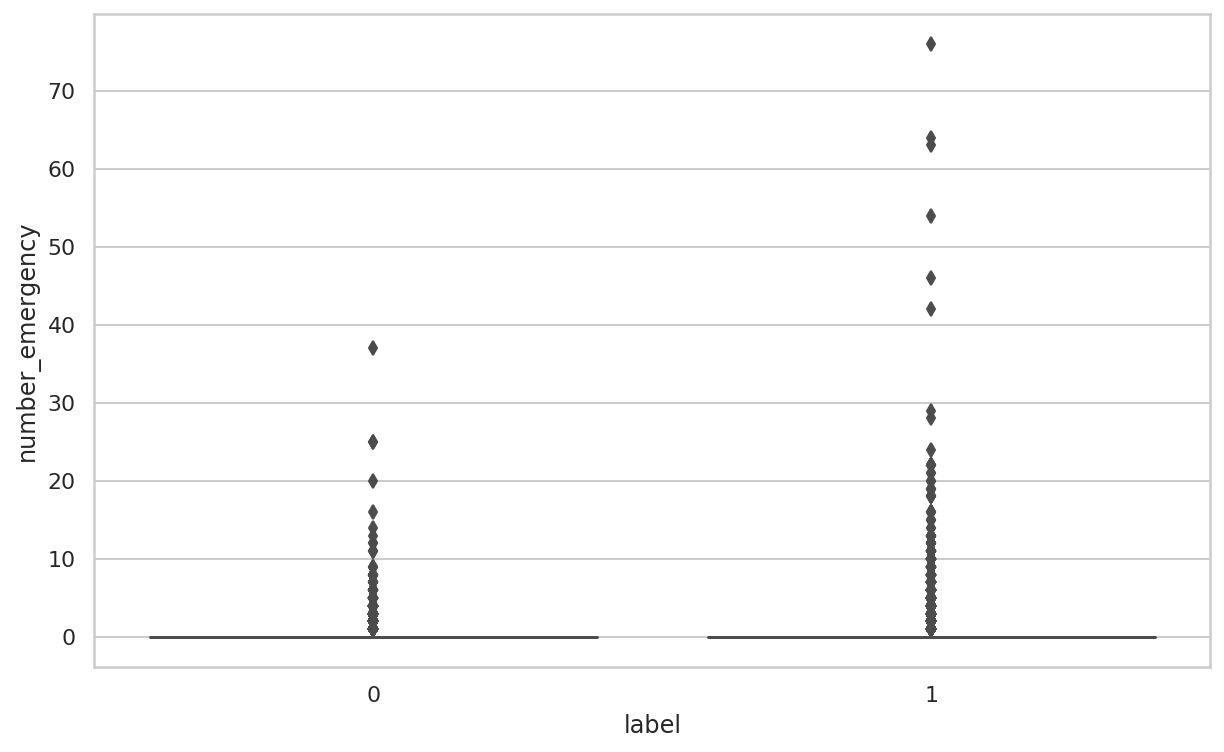

In [47]:
boxplot_per_classes(df, 'number_emergency', 'label')

Again, a lot of values are equal to 0. How many percent is that?

In [48]:
print(f'{round(len(df[df.number_emergency == 0]) / len(df) * 100, 2)}%')

88.81%


This attribute is very similar to previous one and has even more values equal to 0. Again, it will probably not be used for prediction.

#### number_inpatient

Number of inpatient visits of the patient in the year preceding the encounter.

Similar to two previous attributes.

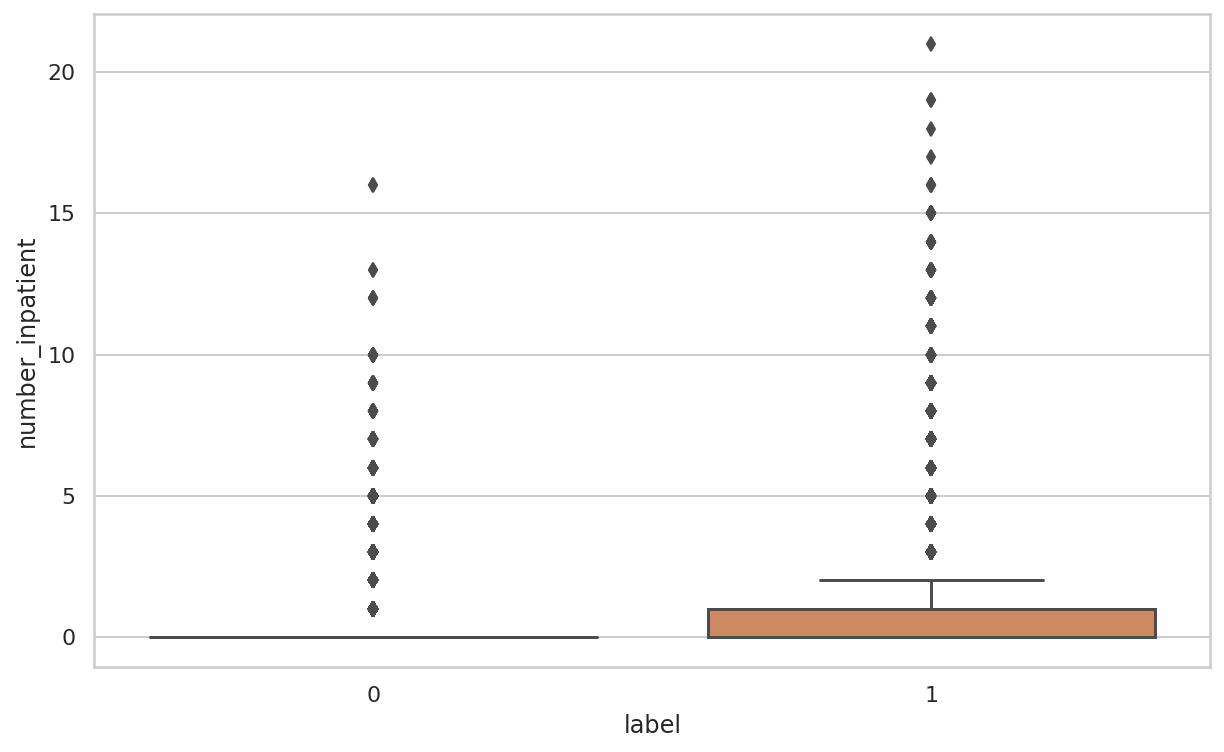

In [49]:
boxplot_per_classes(df, 'number_inpatient', 'label')

### diagnosis
Columns **diag_1**, **diag_2** and **diag_3** are codes for one of the type of diagnose. Here we need create mapping where diagnosis code is mapped to categorical value. We used rules from paper [1] to map more than 700 unique code values to 9 gorups of diagnosis.

In [231]:
df['diag_1'].unique().shape

(717,)

In [232]:
def diagnosis_mapping():
#     list(range(790,800)) + [780, 781, 784, 782] + list(range(240,250) + list(range(251,280) + list(range(680,710)) + list(range(1,140))
    mapping = {}
    mapping['circulatory'] = list(range(390,460)) + [785]
    mapping['respiratory'] = list(range(460,520)) + [786]
    mapping['digestive'] = list(range(520,580)) + [787]
    mapping['diabetes'] = [250]
    mapping['injury'] = list(range(800,1000))
    mapping['musculoskeletal'] = list(range(710,740))
    mapping['genitourinary'] = list(range(580,630)) + [788]
    mapping['neoplasm'] = list(range(140,240))
    all_codes =  reduce(lambda x,y: x + mapping[y] ,mapping.keys(), [])
    mapping['other'] = [x for x in range(1,1000) if x not in all_codes]
    for key in mapping.keys():
        mapping[key] = [str(x) for x in mapping[key]]
    mapping['other'] = mapping['other'] + list(string.ascii_uppercase)
    return mapping

In [233]:
def map_code_to_diagnose(code, mapping):
    code = str(code)
    if not code:
        return None
    for diagnose in mapping.keys():
        if diagnose in ['diabetes', 'other']:
            if any([code.startswith(x) for x in mapping[diagnose]]):
                return diagnose
            else:
                continue
        if code in mapping[diagnose]:
            return diagnose
        
    

In [235]:
mapping = diagnosis_mapping()
df['diag_1_category'] = df['diag_1'].apply(lambda x: map_code_to_diagnose(x, mapping))
df['diag_2_category'] = df['diag_2'].apply(lambda x: map_code_to_diagnose(x, mapping))
df['diag_3_category'] = df['diag_3'].apply(lambda x: map_code_to_diagnose(x, mapping))

#### diag_1
The primary diagnosis (coded as first three digits of ICD9); 848 distinct values

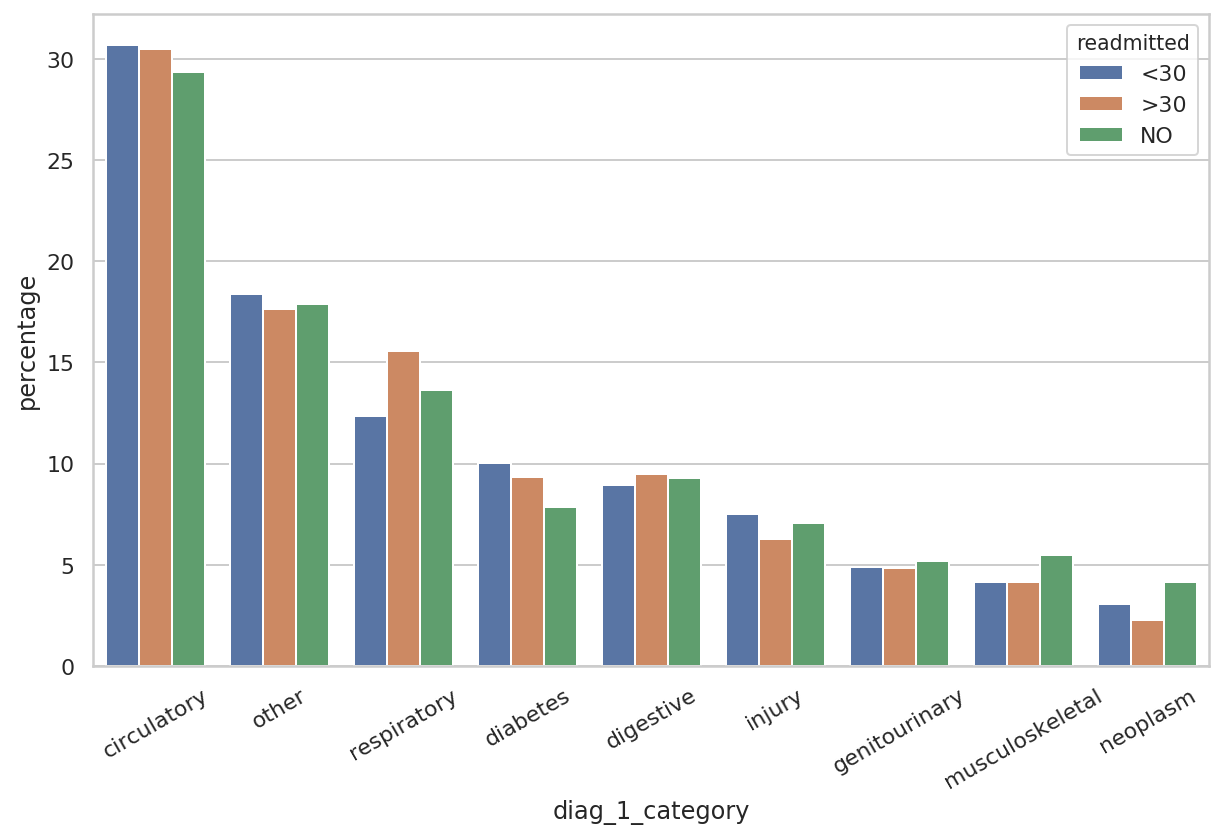

In [375]:
barplot_per_classes(df, 'diag_1_category', 'readmitted', ticks_rotation=30)

Graphs with most common codes in category groups.

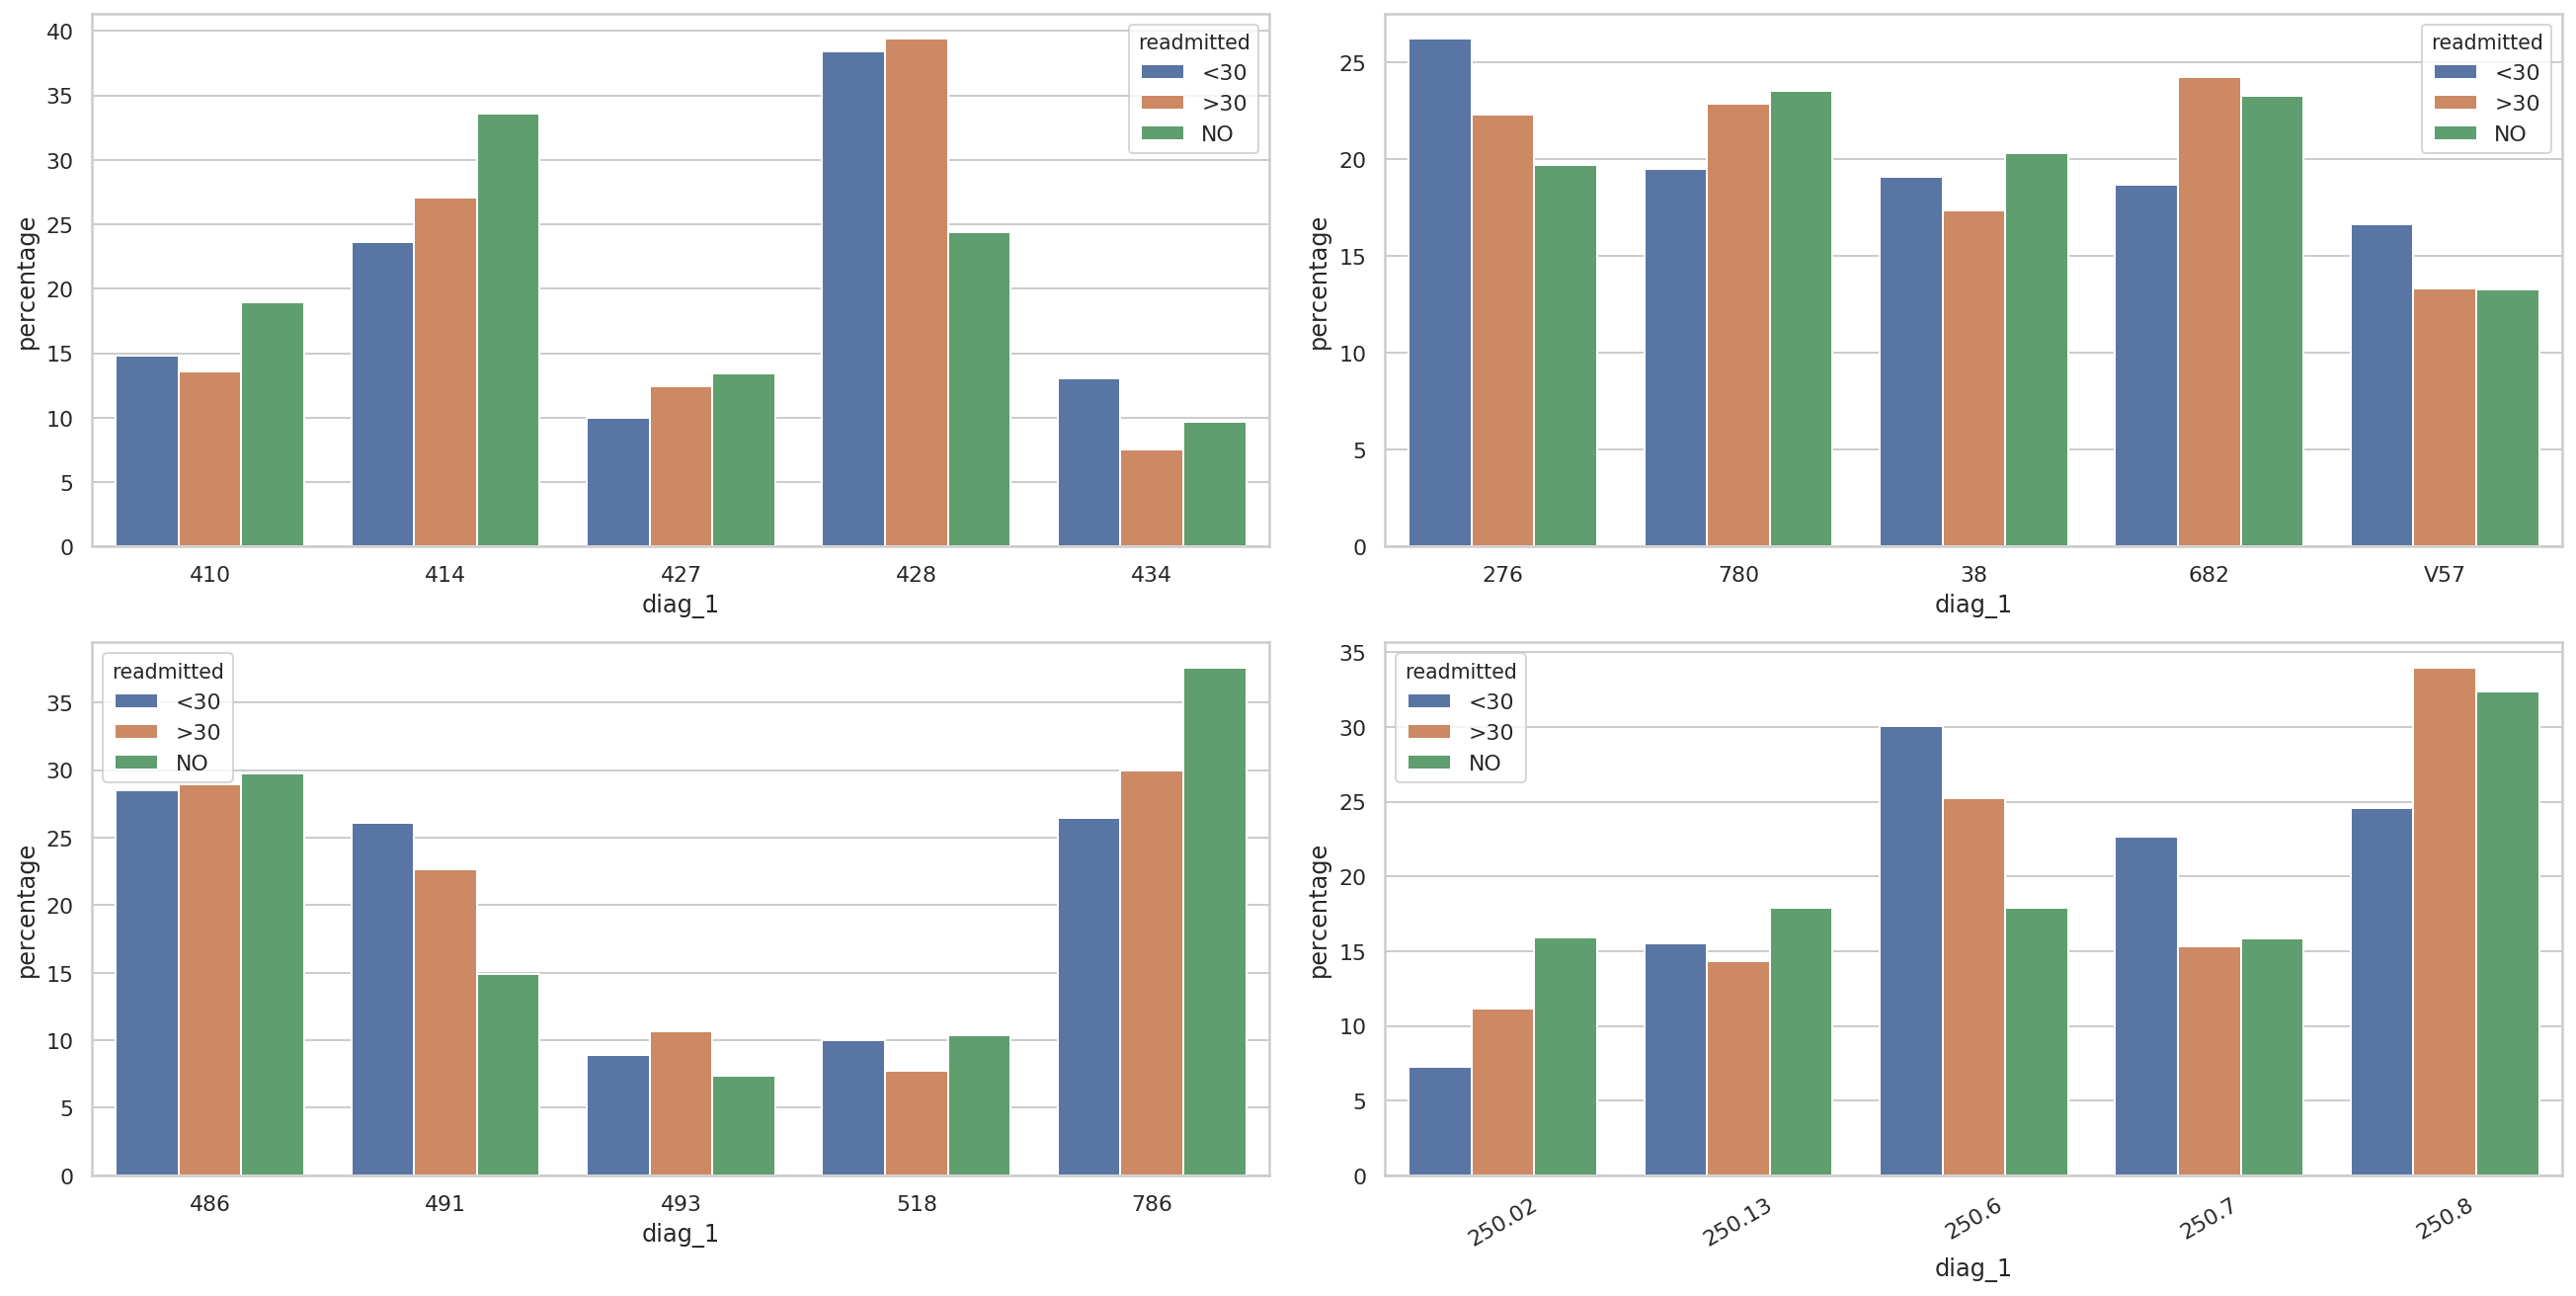

In [331]:
fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
fig.set_size_inches(18, 9)
barplot_per_classes(df[df['diag_1_category'] == 'circulatory'], 'diag_1', 'readmitted', ticks_rotation=30, topn=5, ax=axs[0][0])
barplot_per_classes(df[df['diag_1_category'] == 'other'], 'diag_1', 'readmitted', ticks_rotation=30, topn=5, ax=axs[0][1])
barplot_per_classes(df[df['diag_1_category'] == 'respiratory'], 'diag_1', 'readmitted', ticks_rotation=30, topn=5, ax=axs[1][0])
barplot_per_classes(df[df['diag_1_category'] == 'diabetes'], 'diag_1', 'readmitted', ticks_rotation=30, topn=5, ax=axs[1][1])

#### diag_2
Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values

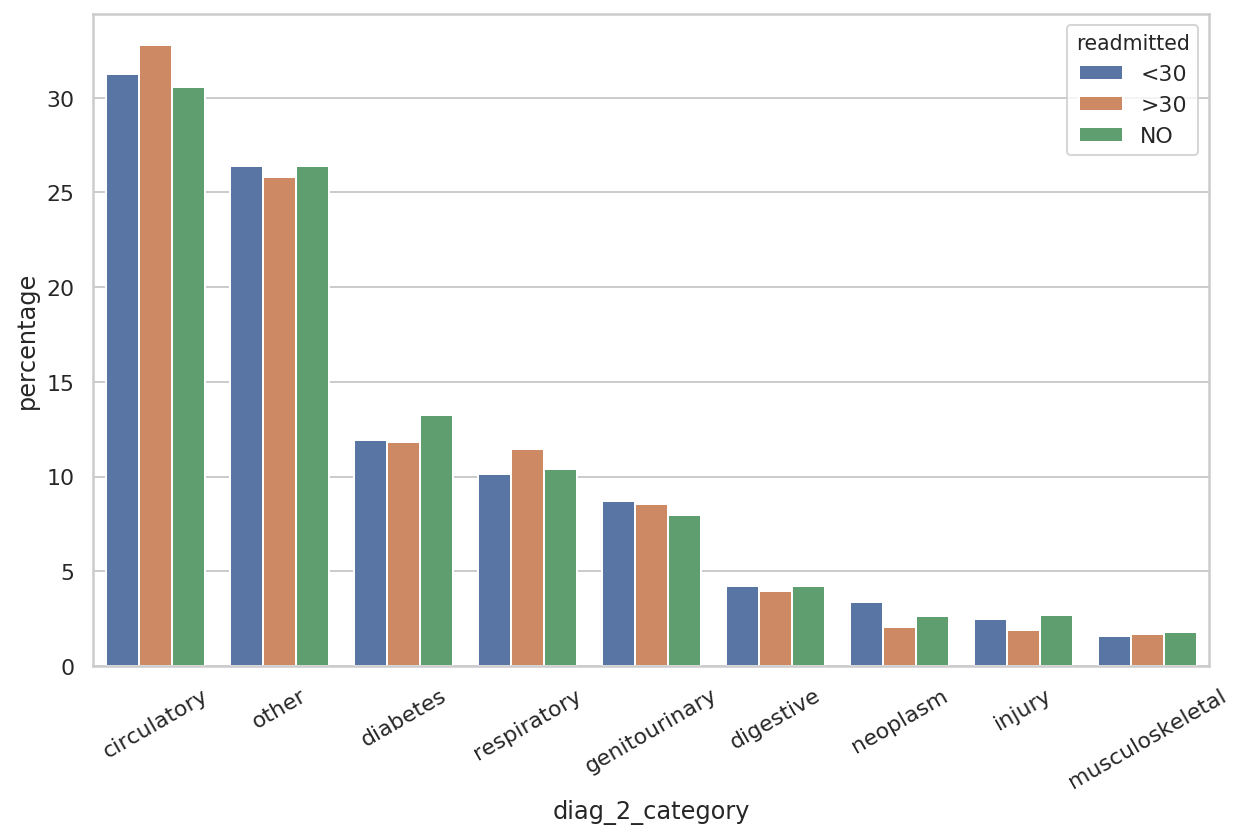

In [374]:
barplot_per_classes(df, 'diag_2_category', 'readmitted', ticks_rotation=30)

#### diag_3
Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values

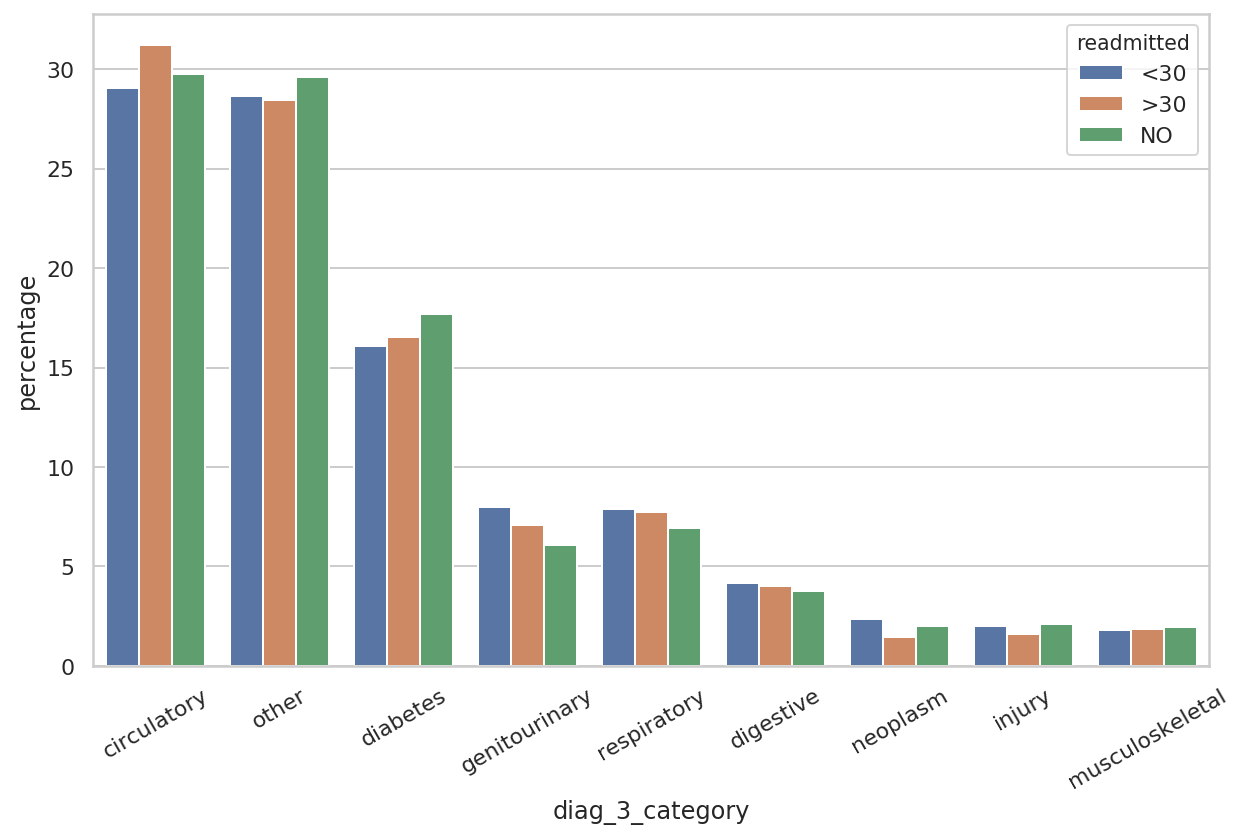

In [373]:
barplot_per_classes(df, 'diag_3_category', 'readmitted', ticks_rotation=30)

#### number_diagnoses
Number of diagnoses entered to the system

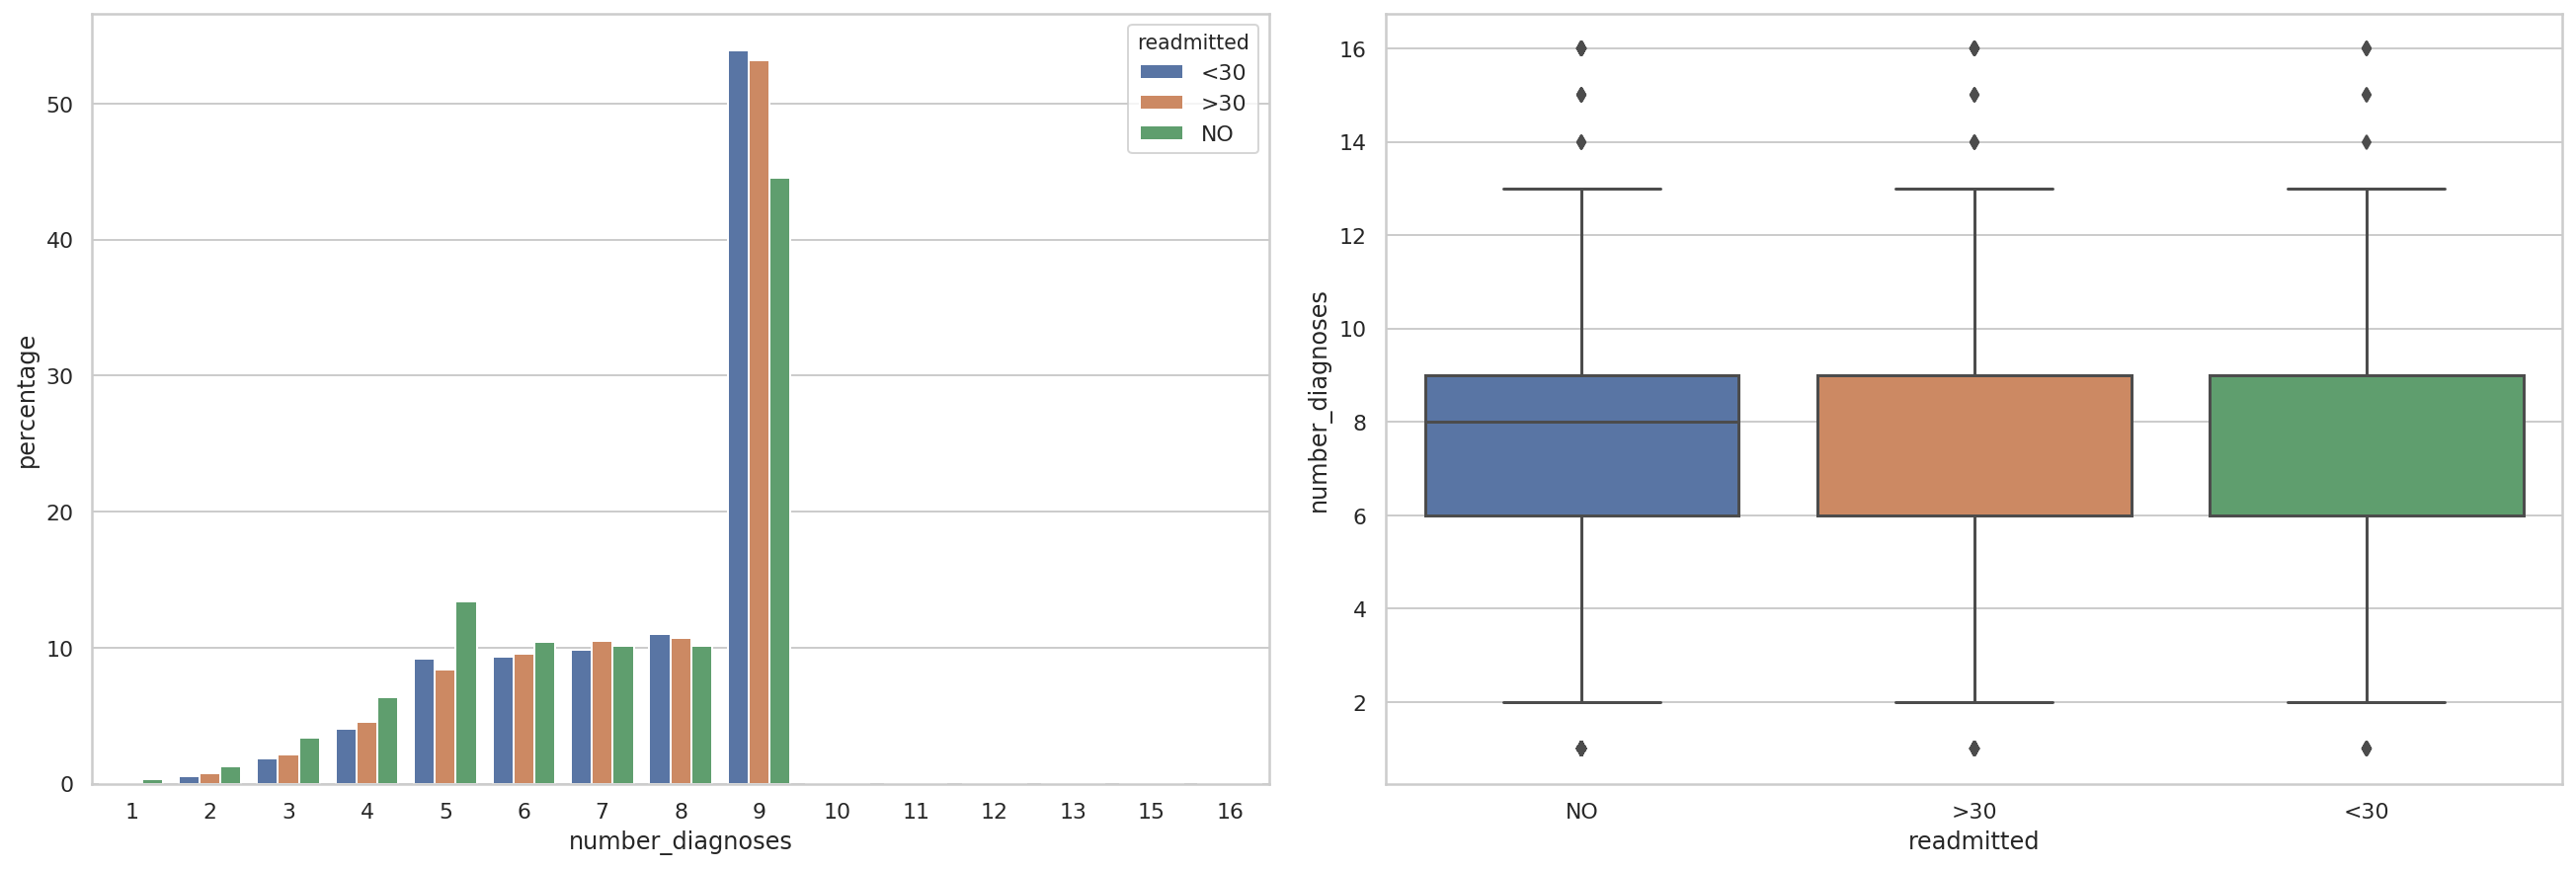

In [332]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
fig.set_size_inches(18, 6)
barplot_per_classes(df, 'number_diagnoses','readmitted', ax=axs[0])
boxplot_per_classes(df, 'number_diagnoses','readmitted', ax=axs[1])

### Medicaments
For the generic names: **metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone**, the feature indicates whether the drug was prescribed or there was a change in the dosage. 
Values: 
* “up” if the dosage was increased during the encounter, 
* “down” if the dosage was decreased, 
* “steady” if the dosage did not change, and 
* “no” if the drug was not prescribed

In [371]:
all_medicaments = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin','glyburide-metformin', 
        'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'metformin']

In [370]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'diag_1_category', 'diag_2_category', 'diag_3_category'],
      dtype='object')

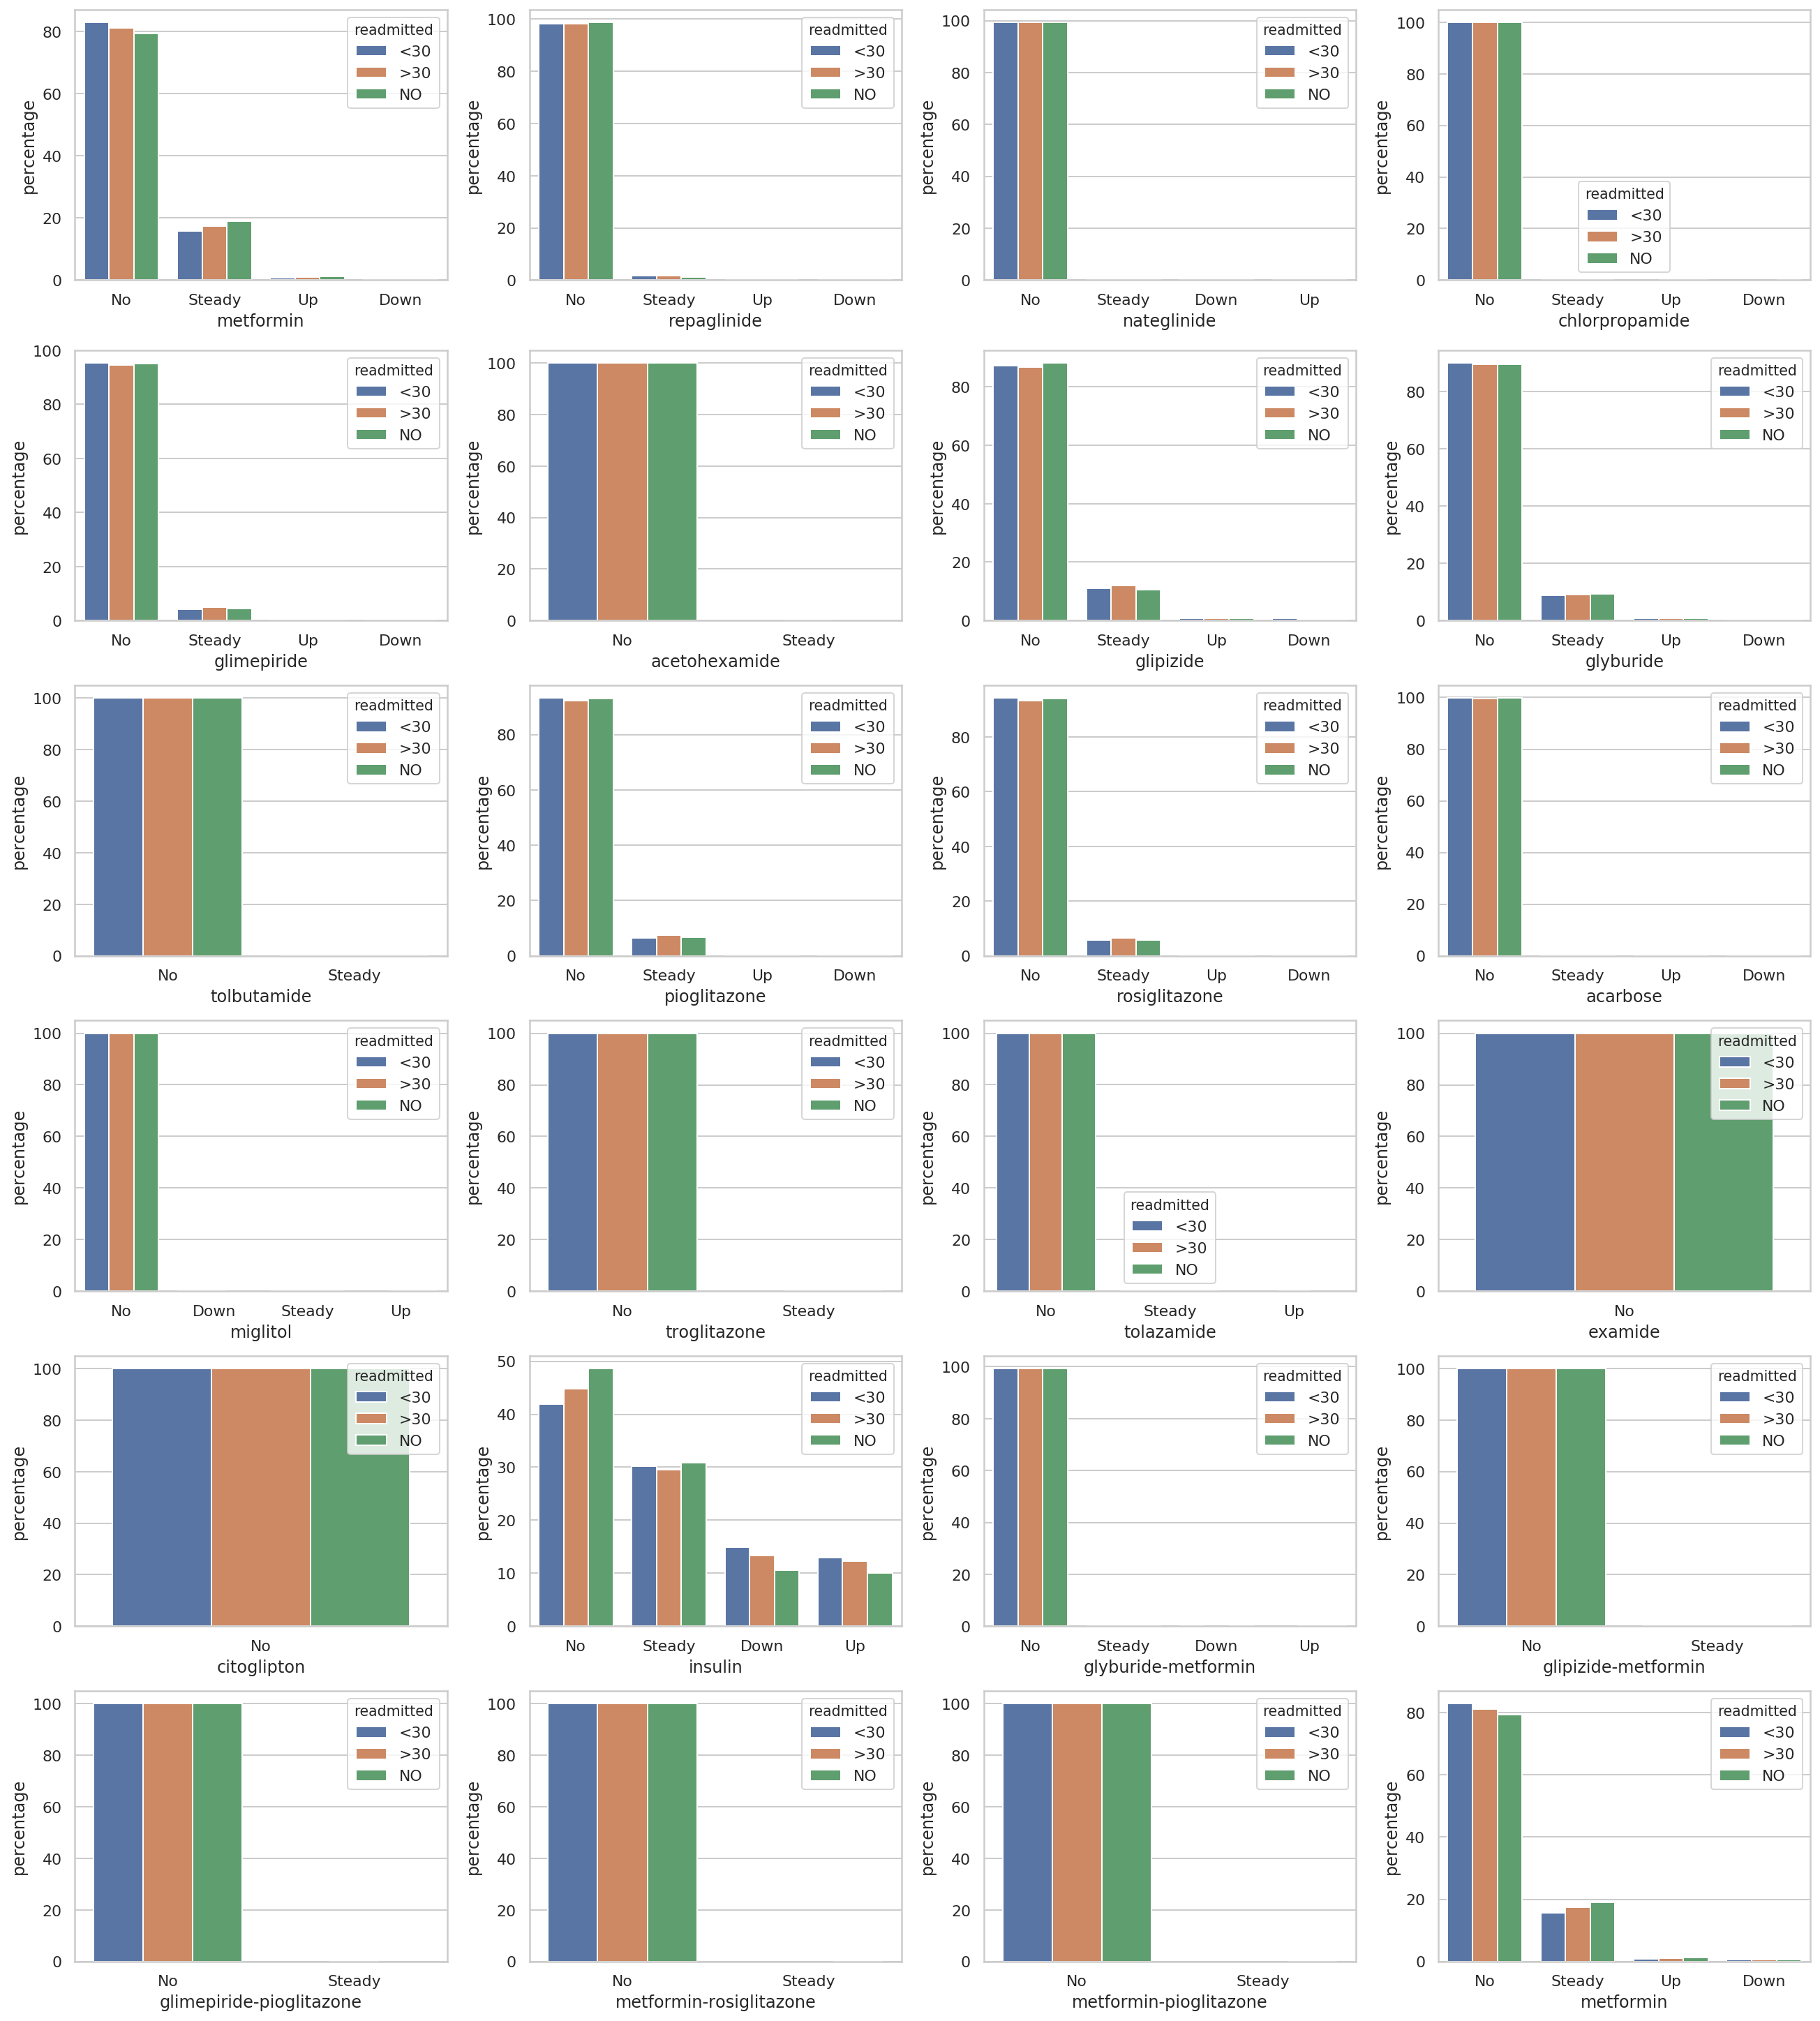

In [372]:
fig, axs = plt.subplots(nrows=6, ncols=4, constrained_layout=True)
fig.set_size_inches(18, 20)
for y in range(0,6):
    for x in range(0,4):
        barplot_per_classes(df, all_medicaments[x + 4 * y],'readmitted', ax=axs[y][x])

#### change
Indicates if there was a change in diabetic medications (either dosage or generic
name). Values: “change” and “no change”

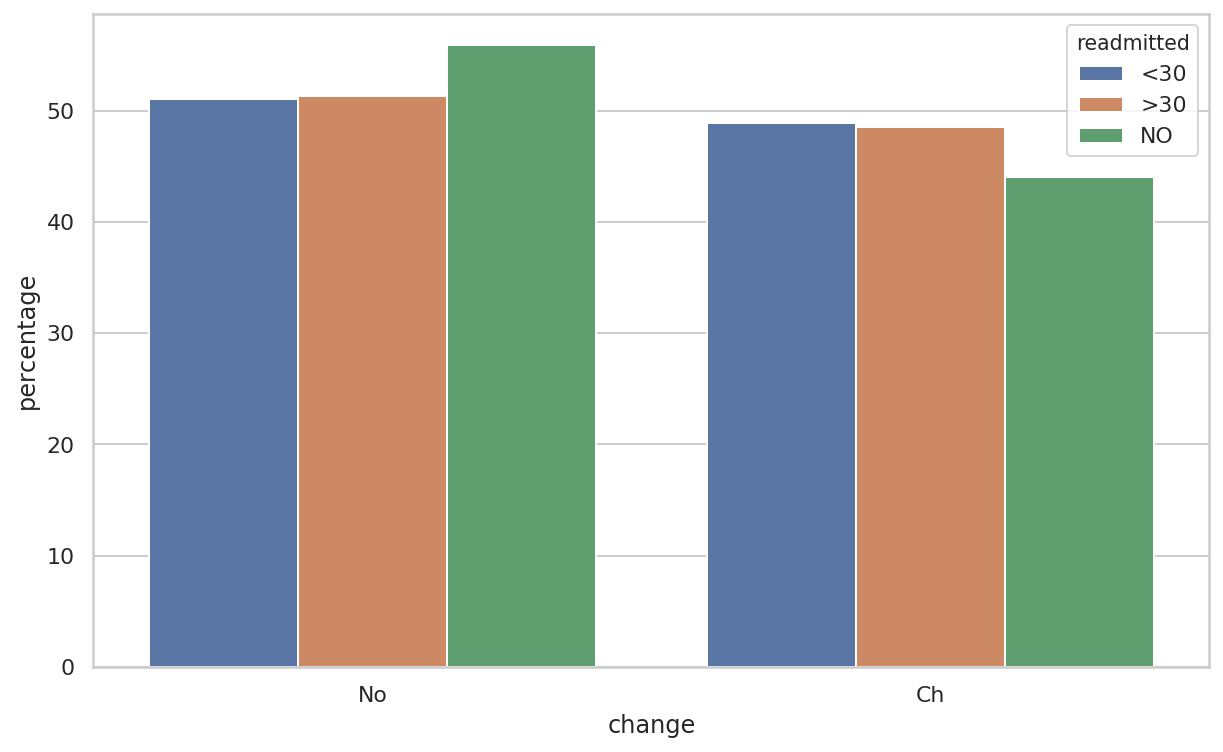

In [378]:
barplot_per_classes(df, 'change', 'readmitted')

#### max_glu_serum
Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,”
“normal,” and “none” if not measured

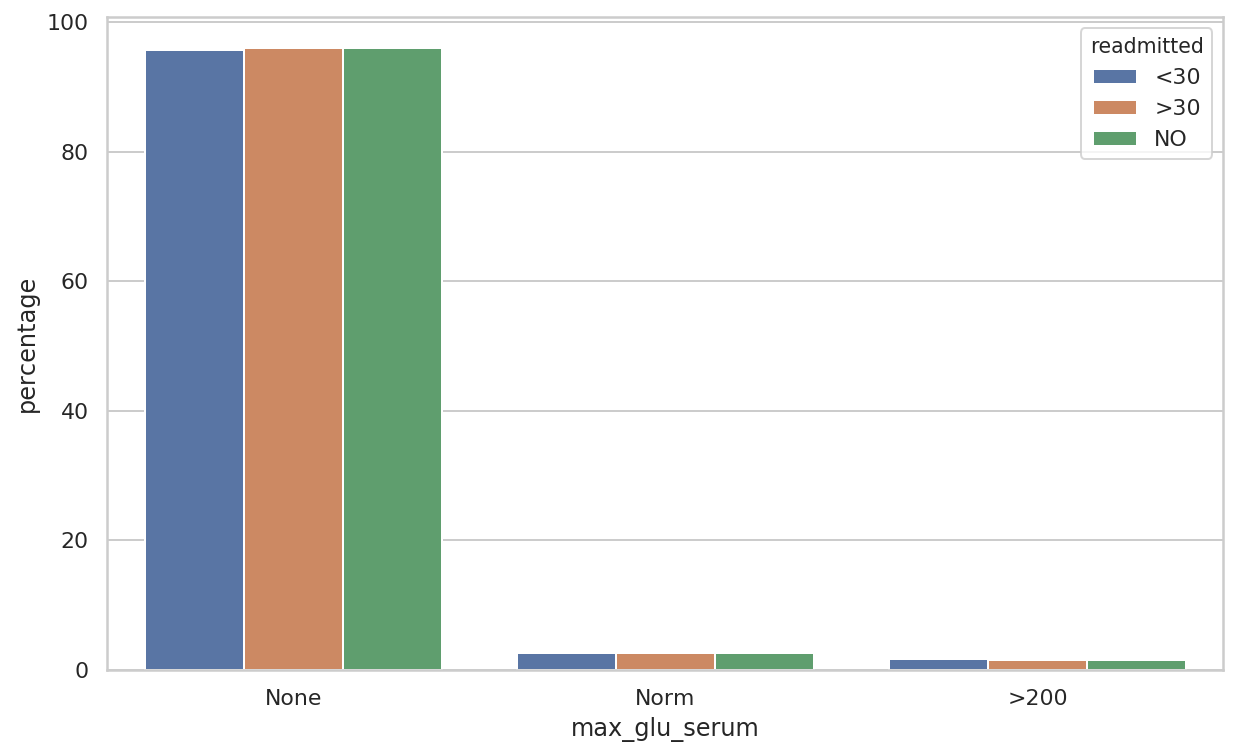

In [341]:
barplot_per_classes(df, 'max_glu_serum', 'readmitted')

#### A1Cresult
Indicates the range of the result or if the test was not taken. Values: “>8” if the result
was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal”
if the result was less than 7%, and “none” if not measured.

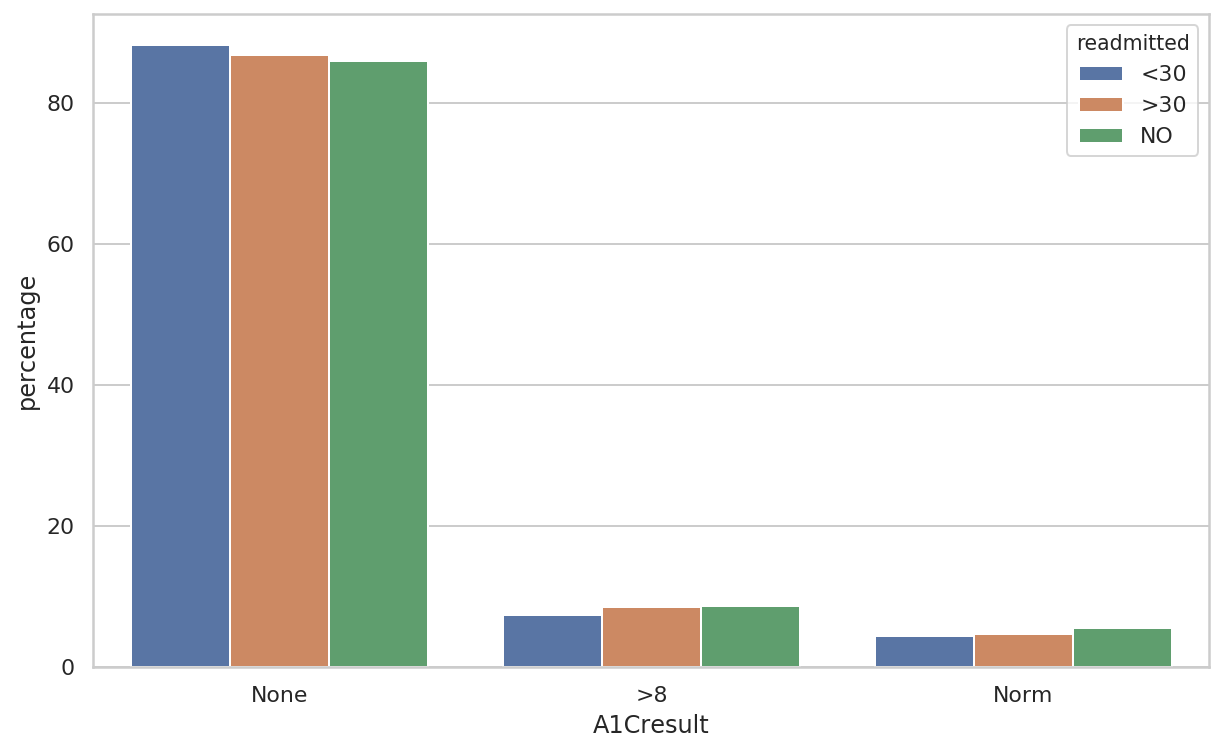

In [343]:
barplot_per_classes(df, 'A1Cresult', 'readmitted')

#### diabetesMed
Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”

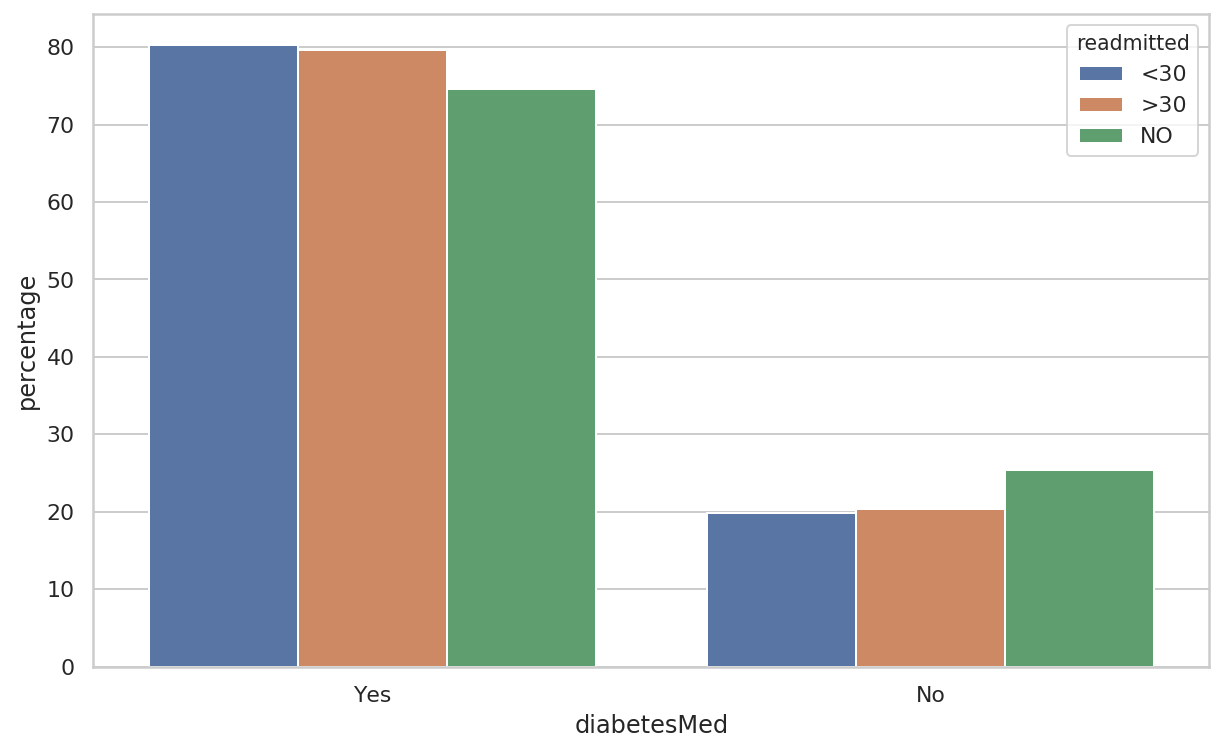

In [377]:
barplot_per_classes(df, 'diabetesMed', 'readmitted')

## TODO
- only attibutes that has missing values will print concrete values with `missing_values` function
- add simple description of each attribute according to paper
- boxplots for numerical attributes

### References
[1] Strack, Beata & Deshazo, Jonathan & Gennings, Chris & Olmo Ortiz, Juan Luis & Ventura, Sebastian & Cios, Krzysztof & Clore, John. (2014). Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records. BioMed research international. 2014. 